# Forest Fire Exploratory Data Analysis
Authors: Rishikesh Majumder, Jake Mitchell, and Peter Kim

Packages Used:

In [95]:
library(dplyr)
library(ggplot2)
library(GGally)
library(ggcorrplot)
library(ggpubr)
library(car)
require(gridExtra)

### Note:
If you are running this as a notebook, please run the bottom cell with the helper functions after the packages, and before running any graphs.  This was done to keep the code in the report as brief as possible.

## Introduction

### Research Question

In some areas, forest fires are a major environmental concern, endangering human lives and causing substantial economic damage.  We have been given some data on recent fires in a Portuguese park.  Our goal is to better understand what factors influence how severe a forest fire becomes.

### Load Data Set

In [96]:
#forestfire
ff = read.csv("forestfires.csv")

### Data Description

In [97]:
nrow(ff)
names(ff)

[1] 517

[1] "X"     "Y"     "month" "day"   "FFMC"  "DMC"   "DC"    "ISI"   "temp" 
[10] "RH"    "wind"  "rain"  "area"

We see that there are 517 entries in our data set.  There are 13 variables:
1. X - x-axis spatial coordinate within the Montesinho park map
2. Y - y-axis spatial coordinate within the Montesinho park map
3. month - month of the year: “jan” to “dec”
4. day - day of the week: “mon” to “sun”
5. FFMC - Fine Fuel Moisture Code from the FWI system
6. DMC - Duff Moisture Code from the FWI system
7. DC - Drought Code from the FWI system
8. ISI - Initial Spread Index  from the FWI system
9. temp - temperature in Celsius degrees
10. RH - relative humidity in %
11. wind - wind speed in km/h
12. rain - outside rain in mm/m2
13. area - the burned area of the forest (in hectares)

### Data Quality

First we can take a look at each of the 8 numerical variables to determine any odd trends.

In [98]:
summary(ff)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

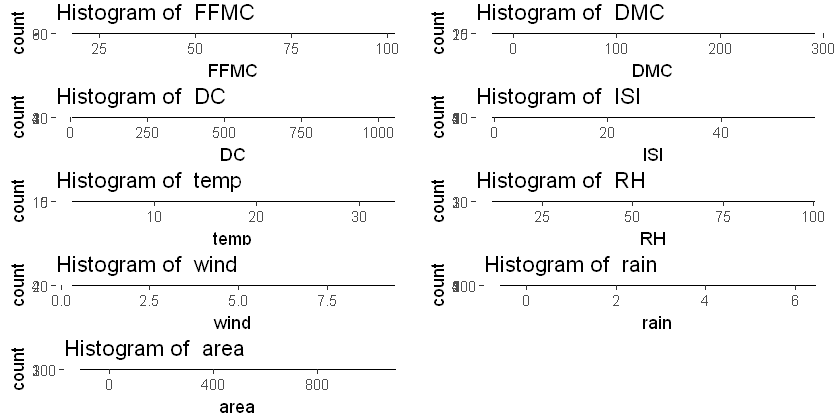

In [99]:
ggarrange(FancyHist(ff, "FFMC"), FancyHist(ff, "DMC"), FancyHist(ff, "DC"), FancyHist(ff, "ISI"), 
          FancyHist(ff, "temp"), FancyHist(ff, "RH"), FancyHist(ff, "wind"), FancyHist(ff, "rain"), 
          FancyHist(ff, "area"), ncol = 2, nrow = 5)

Luckily this data is fairly clean.  There are no missing values and everything can be converted into a numerical form as described later.  However area and rain appear to have an extremely large number of 0 values

In [100]:
print(paste(round(length(ff$rain[ff$rain>0]) /length(ff$rain) *100,2), "% of rain data is non 0."))
print(paste(round(length(ff$area[ff$area>0]) /length(ff$area) *100,2), "% of area data is non 0."))

[1] "1.55 % of rain data is non 0."
[1] "52.22 % of area data is non 0."


Looking deeper into the rain and area statistics, we see that only 1.54% of the rain data and 52.22% of area data is non 0.  For rain this is not surprising, not many fires will occur or spread when rain occurs.  The number of 0 area fires is a problem however.  It may be due to a lack of precision in the area variable, or that a 0 area fire means something that we don't know.  This will cause issues later in the analysis considering the fact that area is our measure of how damaging a fire is.  

Ultimately this data is not of the highest quality because our severity indicator, area, is very imbalanced.  The other statistics seem fine, and we will look closer at the rest of them later.  To get around the area data issue, we will assume fires with 0 area are extremely small and below the precision of the metric.  These may be fires around the size of a campsite, which would fall below our hundredths place accuracy. 

### Data Processing

Taking the log of the area variable will also make visualizing the relationships between it and other variables easier later.  We can take the log of all of the area values.  This does have the unfortunate side effect of producing -Inf for all of the 0 area value rows however.  This will be dealt with by only using this logArea in situations where we know the area of fires is non 0, specifically by using the big/severe fire sets.

In [101]:
ff$logArea = log(ff$area)

In order to combat the imbalanced area data, we will look at 4 levels of fires: all fires, non 0 fires, big fires, and severe fires.  First we need to find where to put the splits between general, big and severe fires.  

In [102]:
#Non 0 fires
nff = ff[ff$area>0,]
print(paste("There are", nrow(nff), "non 0 fires"))
quantile(nff$area, .90)
quantile(nff$area, .66)

[1] "There are 270 non 0 fires"


90% 
46.885

66% 
10.107

We see that we have 270 fires with a non 0 area.  If we assume the most severe fires to be the top 10% of non 0 area fires, that would correlate to fires with an area greater than around 45 hectares.  If we want to look at all significant fires, we can look at the top third, which would be fires over 10 hectares.

In [103]:
#big fires
bff = ff[ff$area>10,]
#severe fires
sff = ff[ff$area>50,]

## Univariate Analysis

### XY Coordinates

When we take a look at the XY locations of the fires we notice something interesting.  All of the fires are grouped in the lower half of the park.  

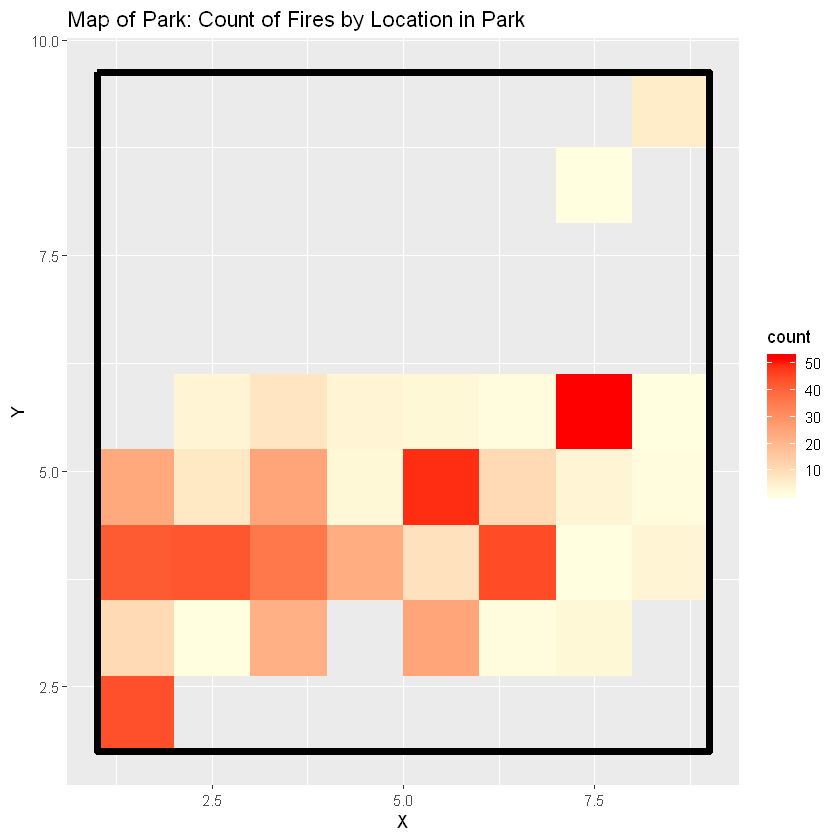

In [104]:
options(repr.plot.width=7, repr.plot.height=7)
ggplot(ff, aes(x=X, y=Y)) + 
  geom_bin2d(bins=8) + 
  scale_fill_gradient(low= "light yellow", high="Red") +
  geom_rect(xmin=1, xmax=9, ymin=1.75, ymax=9.625, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Count of Fires by Location in Park")

This shows us that almost all of the fires have occured between (1,1) and (8,6), with very few exceptions.  If this correlates to N/S/E/W, then the southern half of the park is much more prone to fires than the rest of the park. 

### Month/Area and Month/Temp

In [105]:
bff %>%
    group_by(month) %>%
    summarize(count = length(area), mean(area), maxar = max(area), maxt = max(temp), meant = mean(temp),
    median(area), sum(area)) %>%
    arrange(desc(maxar))
          

month,count,mean(area),maxar,maxt,meant,median(area),sum(area)
sep,39,73.72872,1090.84,28.3,20.06923,29.480,2875.42
aug,30,69.16367,746.28,33.3,22.42000,27.585,2074.91
jul,3,134.00000,278.53,26.9,20.96667,86.450,402.00
jun,2,40.20000,70.32,26.4,25.45000,40.200,80.40
apr,2,36.03000,61.13,13.7,9.75000,36.030,72.06
feb,3,29.69000,51.78,10.1,8.80000,24.240,89.07
oct,3,29.10000,49.37,20.2,18.23333,24.230,87.30
may,1,38.48000,38.48,18.0,18.00000,38.480,38.48
mar,7,25.63857,36.85,17.0,14.10000,28.660,179.47
dec,5,17.31400,24.77,5.1,4.80000,17.850,86.57


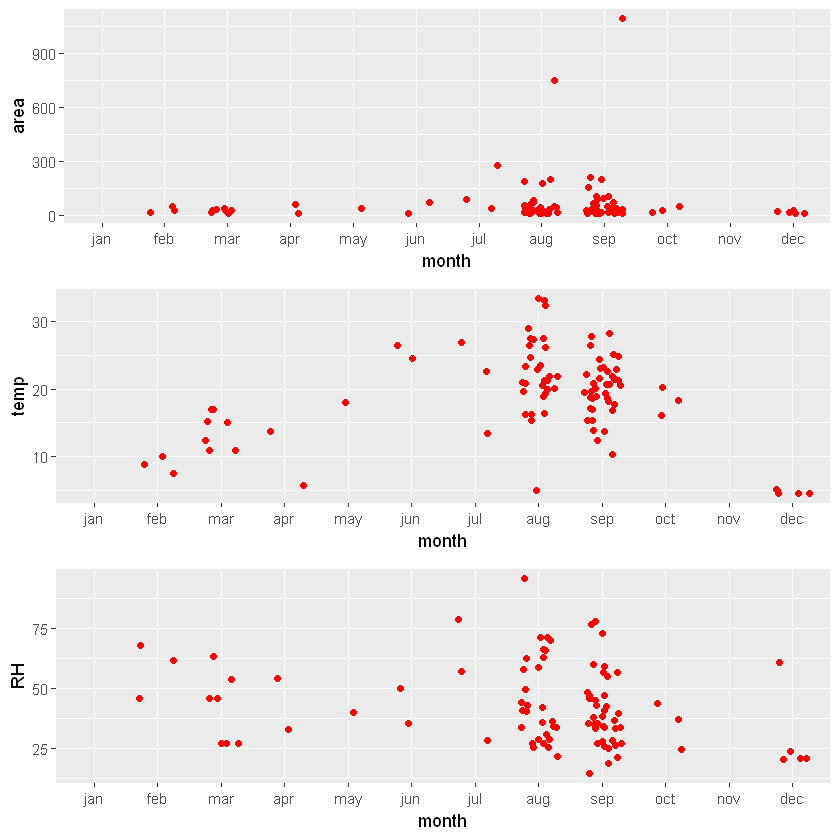

In [106]:
#Area by month
arMonth <- ggplot()+
geom_jitter(aes(month, area), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

#Temp by month
tempMonth <- ggplot()+
geom_jitter(aes(month, temp), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

#Temp by rh
rhMonth <- ggplot()+
geom_jitter(aes(month, RH), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))

ggarrange(arMonth, tempMonth, rhMonth,
          ncol = 1, nrow = 3)

### FFMC (Fine Fuel Moisture Code)

In [107]:
summary(ff$FFMC)
sd(ff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.70   90.20   91.60   90.64   92.90   96.20 

[1] 5.520111

What we notice from the summary is that the data is fairly compact, it only has a standard deviation of 5.5.  Unfortunately we don't know the units of this variable, but we can tell that most fires occur with a very high FFMC.

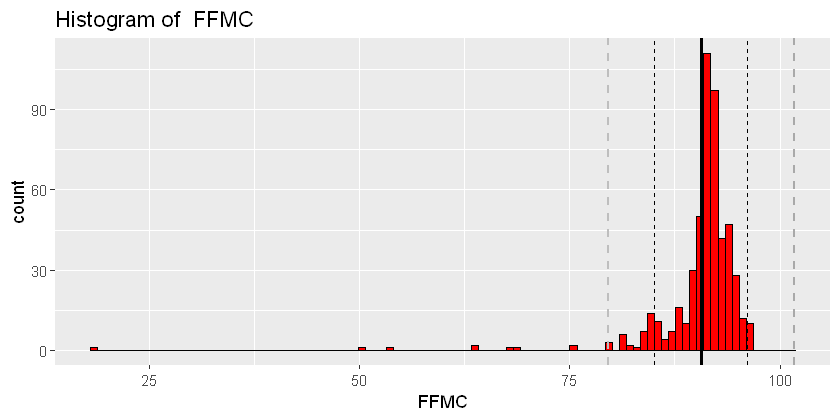

In [108]:
FancyHist(ff, "FFMC")

Looking at the histogram we confirm what we saw in the summary, the data is very heavily left skewed.  The outliers may be worth looking at later in relation to the area of a fire.

### DC (Drought Code)

In [109]:
summary(ff$DC)
sd(ff$DC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    7.9   437.7   664.2   547.9   713.9   860.6 

[1] 248.0662

Looking at the basic summary of the variable, we notice that it has an extremely large range but all the values seem useful.  There are no 0 or NA values.

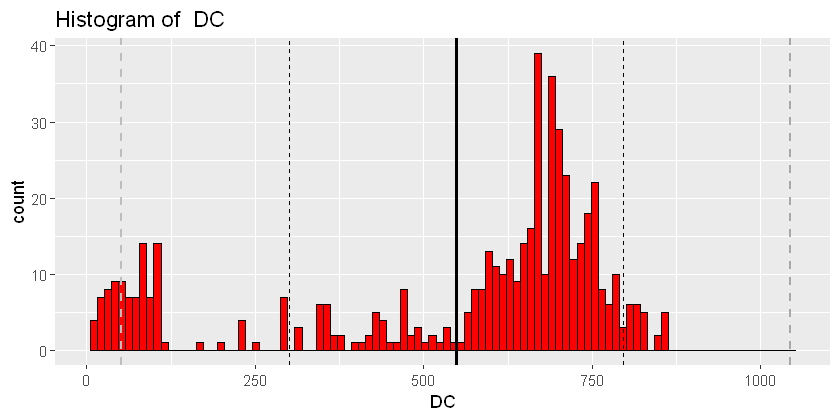

In [110]:
FancyHist(ff, "DC")

Here we notice that the data is fairly bimodal, and has a decently size left skew.  It will be interesting to look into the different types of fires that each clump represents.  Splitting based on the mean could give us a decent grasp of that.  

### DMC (Duff Moisture Code)

In [111]:
summary(ff$DMC)
sd(ff$DMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.1    68.6   108.3   110.9   142.4   291.3 

[1] 64.04648

First thing I notice is that there is a massive range in these values, from 1.1 to 291.3.  The mean is also at around 1/3 of the total range.

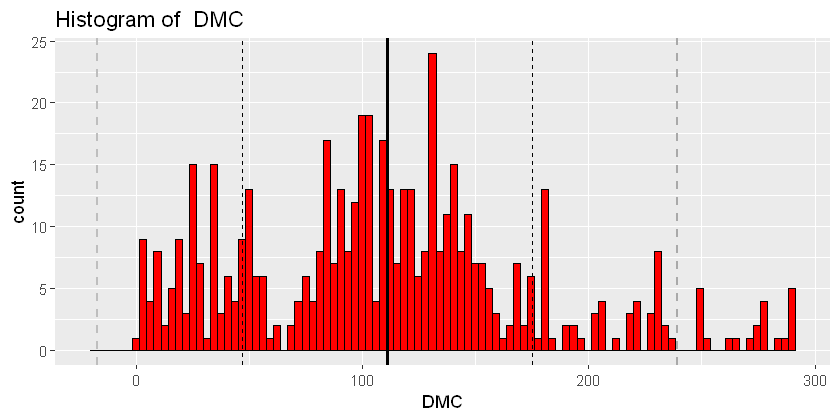

In [112]:
FancyHist(ff, "DMC")

All things considered this looks like fairly well distributed data.  Yes there is a massive range, but there are no major outliers.  There is a very slight right skew.  Also there is a lot of granularity in the data as it goes down to the tenth.

### ISI (Initial Spread Index)

In [113]:
summary(ff$ISI)
sd(ff$ISI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   6.500   8.400   9.022  10.800  56.100 

[1] 4.559477

The ISI data seems fairly compact, but has an extremely high maximum.  We can use a histogram to take a loot at it.

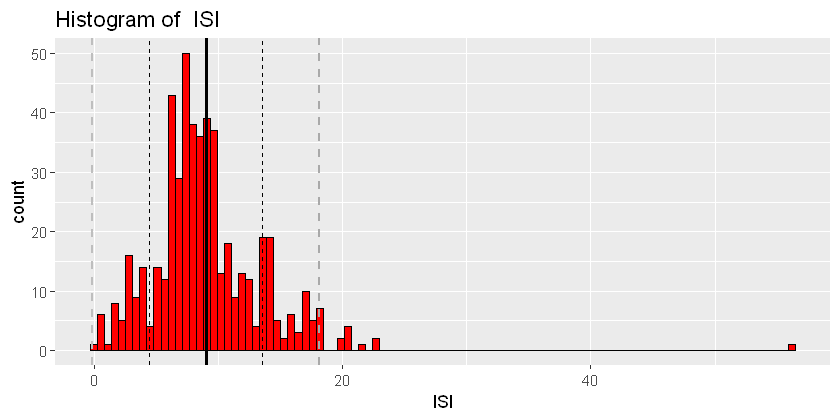

In [114]:
FancyHist(ff, "ISI")

In [115]:
ff[which.max(ff$ISI),]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
23,7,4,jun,sun,94.3,96.3,200,56.1,21,44,4.5,0,0,-Inf


There doesn't seem to be too much odd about this data point. The FFMC, DMC, and DC are in normal limits. The temp is barely elevated. The area is marked as 0 as well. The only thing remarkable about this point is the extremely high ISI. If I understand the Initial Spread Index correctly, this was a fire that spread extremely rapidly, but was put out before it grew at all.

In anycase, ISI should behave well for later analysis with area.

### Temperature

In [116]:
summary(ff$temp)
sd(ff$temp)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.20   15.50   19.30   18.89   22.80   33.30 

[1] 5.806625

Seems like a decent range, although it covers almost every temperature from 100\*F to freezing.

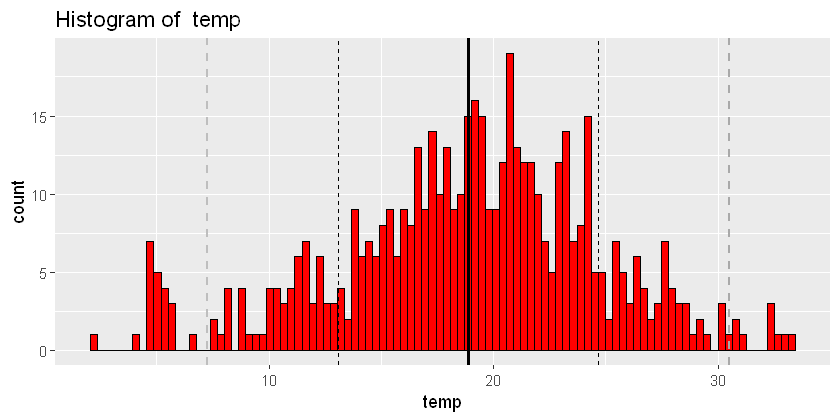

In [117]:
FancyHist(ff, "temp")

This data is remarkably well distribued, with the average just slightly below room temperature.

#### Relative Humidity

#### Wind

#### Rain

## Key Relationships

# _I am putting general relationship analysis here.  We can move it to appropriate locations soon_

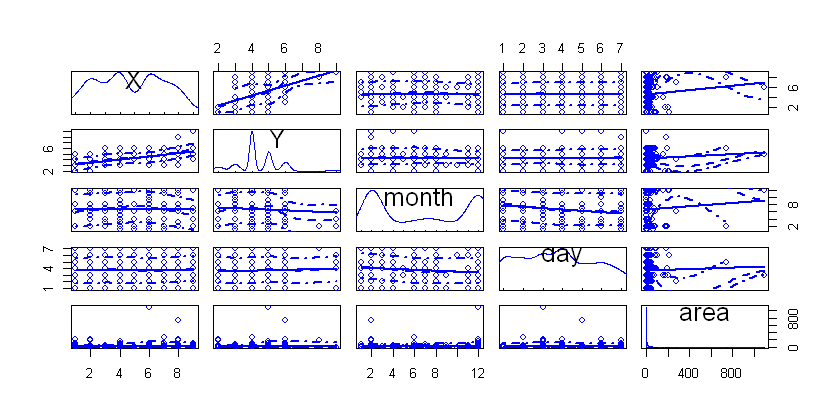

Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit negative part of the spread"Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"

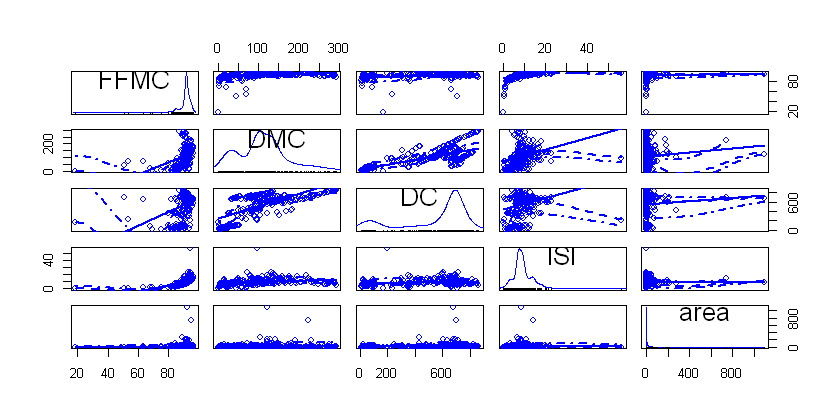

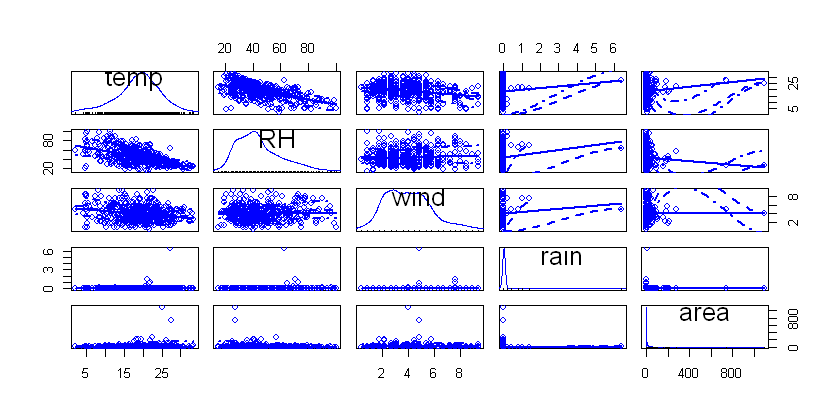

In [118]:
#3. Evaluate the data quality
# - Are there any issuews with data
# - Explain how you handled these potential issues
#options(repr.plot.height = 10, repr.plot.width = 10, repr.plot.pointsize = 22)
scatterplotMatrix(~X+Y+month+day+area, data=ff)
scatterplotMatrix(~FFMC+DMC+DC+ISI+area, data=ff)
scatterplotMatrix(~temp+RH+wind+rain +area, data=ff)

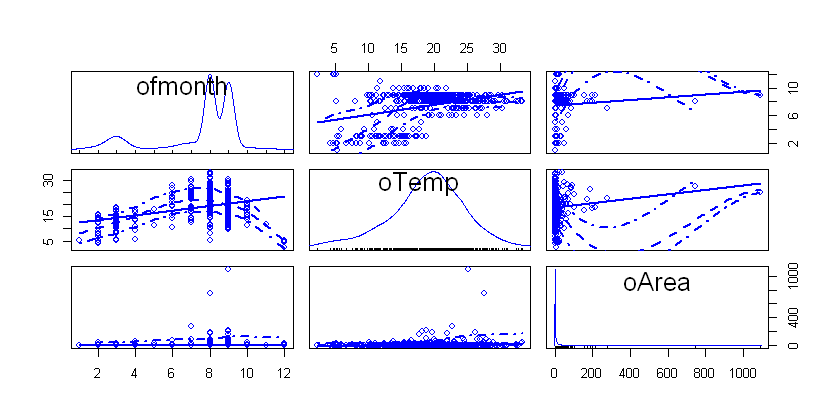

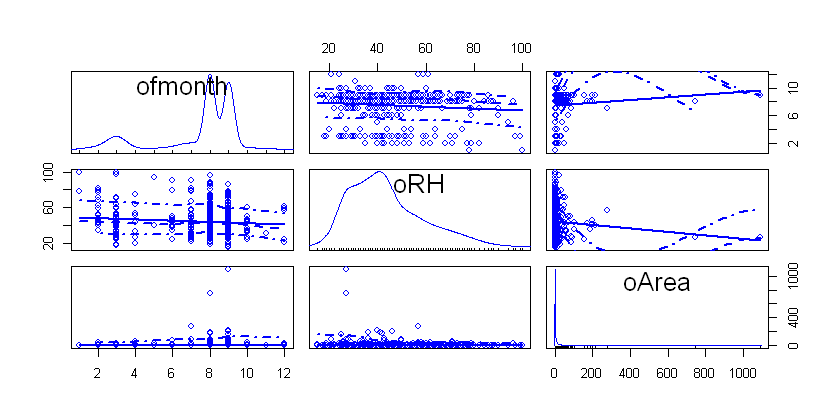

In [119]:
off=ff[order(ff$area),]
ofmonth=factor(off$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))

# Entire data
oRH=off$RH
oTemp=off$temp
oArea=off$area
frame_data = data.frame(ofmonth, oArea, oRH, oTemp)

scatterplotMatrix(~ofmonth+ oTemp+ oArea, data=frame_data)
scatterplotMatrix(~ofmonth+ oRH+ oArea, data=frame_data)

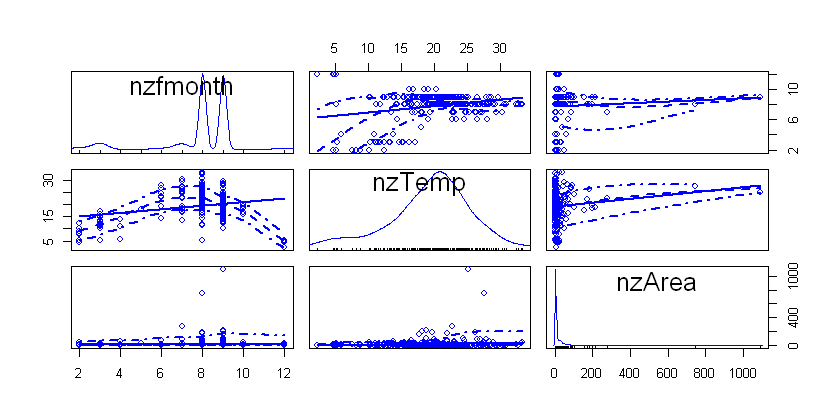

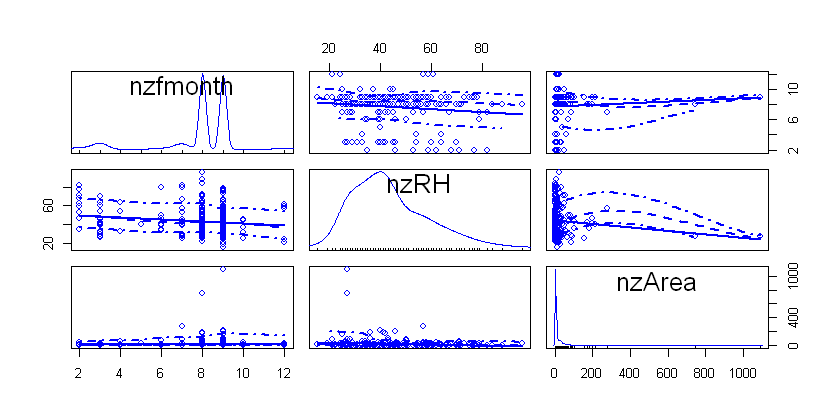

In [120]:
# Only non-zero data
L_zero=length(oArea[oArea==0])
nzArea= oArea[oArea>0]

nzff=off[248:517,]
nzfmonth=factor(nzff$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))

nzRH=oRH[248:517]
nzTemp=oTemp[248:517]
nzArea=oArea[248:517]
nzlArea=log(oArea[248:517]+10)
frame_nzdata = data.frame(nzfmonth,nzArea, nzRH, nzTemp, nzlArea)


scatterplotMatrix(~nzfmonth+ nzTemp+ nzArea, data=frame_nzdata)
scatterplotMatrix(~nzfmonth+ nzRH+ nzArea, data=frame_data)

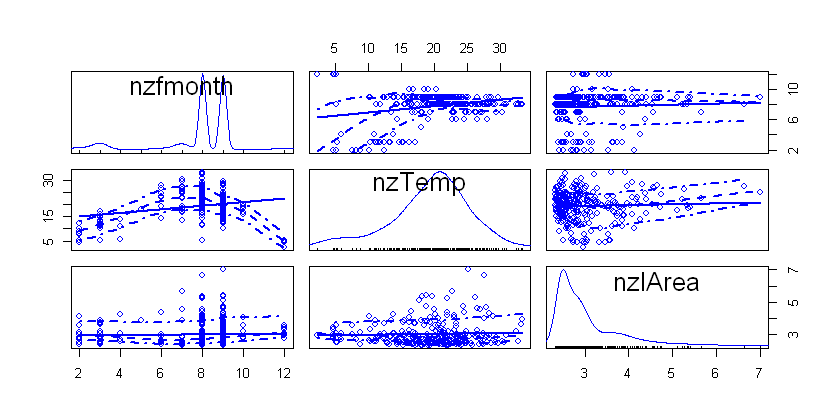

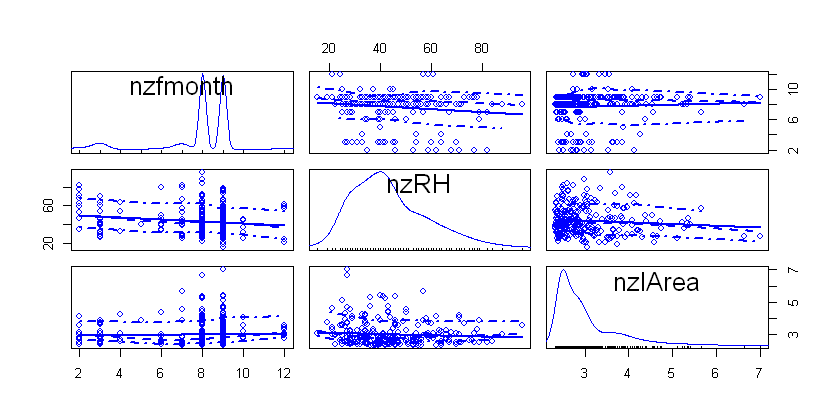

In [121]:
scatterplotMatrix(~nzfmonth+ nzTemp+ nzlArea, data=frame_nzdata)
scatterplotMatrix(~nzfmonth+ nzRH+ nzlArea, data=frame_data)

Warning message:
"Removed 10857 rows containing non-finite values (stat_smooth)."

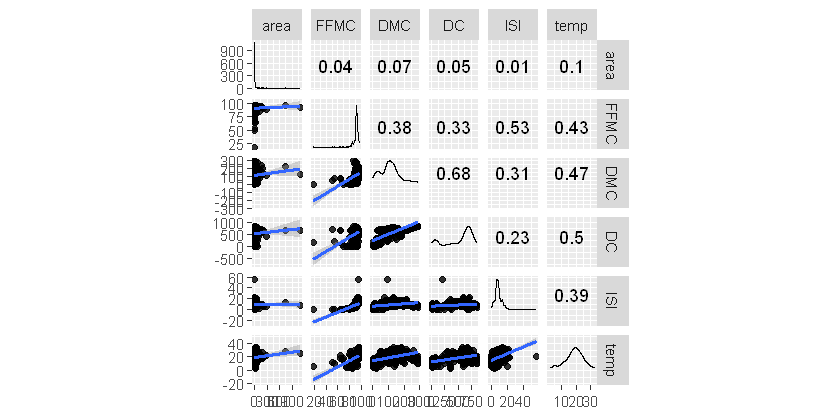

In [122]:
ggscatmat(ff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

There is a lot of colinearity in these variables. The highest correlation between any of the variables is between DC and DMC, with a 0.68. This means that our secondary effects write up will be full of interactions between FFMC, DMC, DC, ISI, and Temp. They are all extremely related to each other.

Warning message:
"Removed 1995 rows containing non-finite values (stat_smooth)."

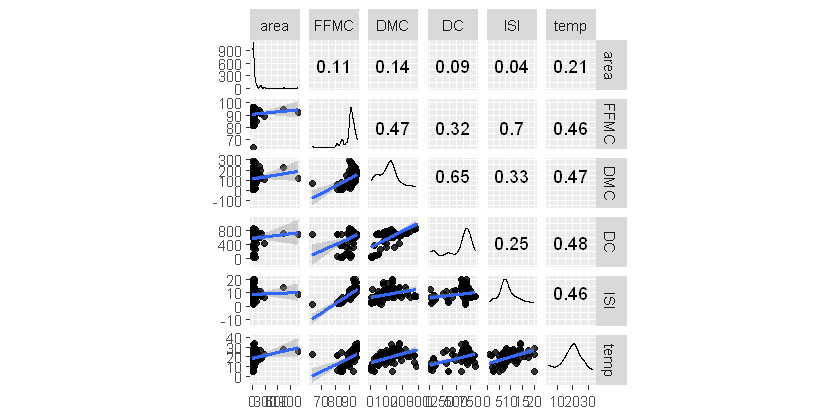

In [123]:
ggscatmat(bff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Warning message:
"Removed 504 rows containing non-finite values (stat_smooth)."

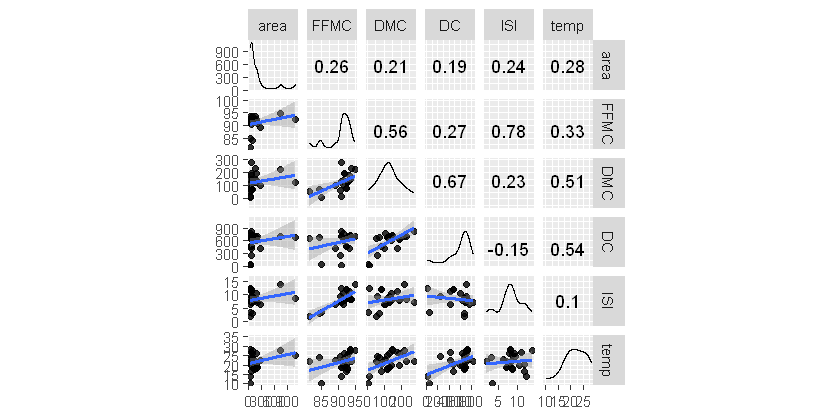

In [124]:
ggscatmat(sff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Looking at only the severe fires we can see that the correlation between each variable and the severity (area) become much more pronounced, up to a 0.28 between temp and area.

Warning message:
"Removed 210 rows containing non-finite values (stat_smooth)."

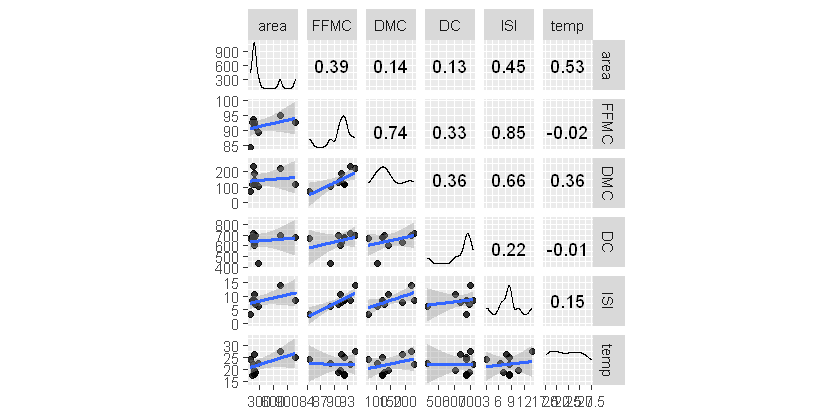

In [125]:
ggscatmat(sff[order(sff$area, decreasing=T)[1:10],c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

These correlations get even stronger as we are looking at the most damaging fires. The top 10 fires in the park. Temperature and area are extremely correlated.

# _Peter: Here is your code for the key relationship stuff, Move it where you think it will fit the best_

In [126]:
# Create factor for month
off=ff[order(ff$area),]
ofmonth=factor(off$month, levels = c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep","oct", "nov", "dec"))
ofday=factor(off$day, levels = c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))

# Entire data
oRH=off$RH
oTemp=off$temp
oArea=off$area
oLogArea=log(off$area+1)

oFFMC=off$FFMC
oDMC=off$DMC
oDC=off$DC
oISI =off$ISI

# create data frame
frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
frame_data2 = subset(frame_data, oArea>10)

## Key Area Relationships

# _Peter: you may want to make some of this stuff a function, since so much of the code is reused.  It may make the report more readable. You could arrange all those individual graph in row/column, for less scrolling. Have put an example at the top_


### XY Coordinates

While looking at the count of fires that appear at all locations is helpful, in order to see what coordinates lead to big fires we need to look at the sizes of these fires.  Just the count tells us where they have happened before and tells us that we will have better predicting powers in the bottom half of the park, but does not help us predict where the next big one might be.

In [127]:
ffXYgroup = bff %>%
    group_by(X, Y) %>%
    summarize(logMeanArea = log(mean(area)), meanArea = mean(area), medianArea = median(area), count = length(area), totalArea = sum(area), maxArea = max(area))
ffXYgroup[ffXYgroup==-Inf] <- 0

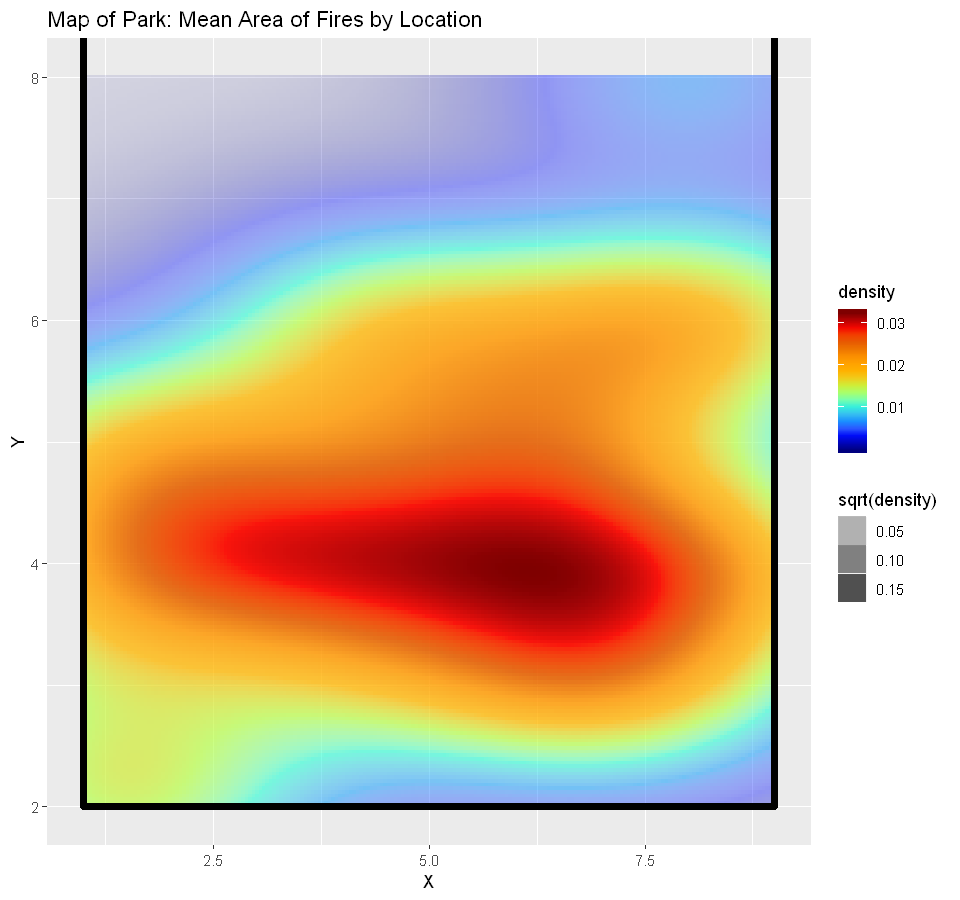

In [128]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))
options(repr.plot.width=8, repr.plot.height=7.5)

ggplot(ffXYgroup, aes(X, Y, density = logMeanArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density.., alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Mean Area of Fires by Location")

Finally once we apply some smoothing and coloring functions to the data we end up with a heatmap of the park that shows where the largest fires are most likely to occur.  It appears that if fires occur around (6,4) they are the most likely to become severe.  This is something that could be worked into a fire severity prediction model.

### Month

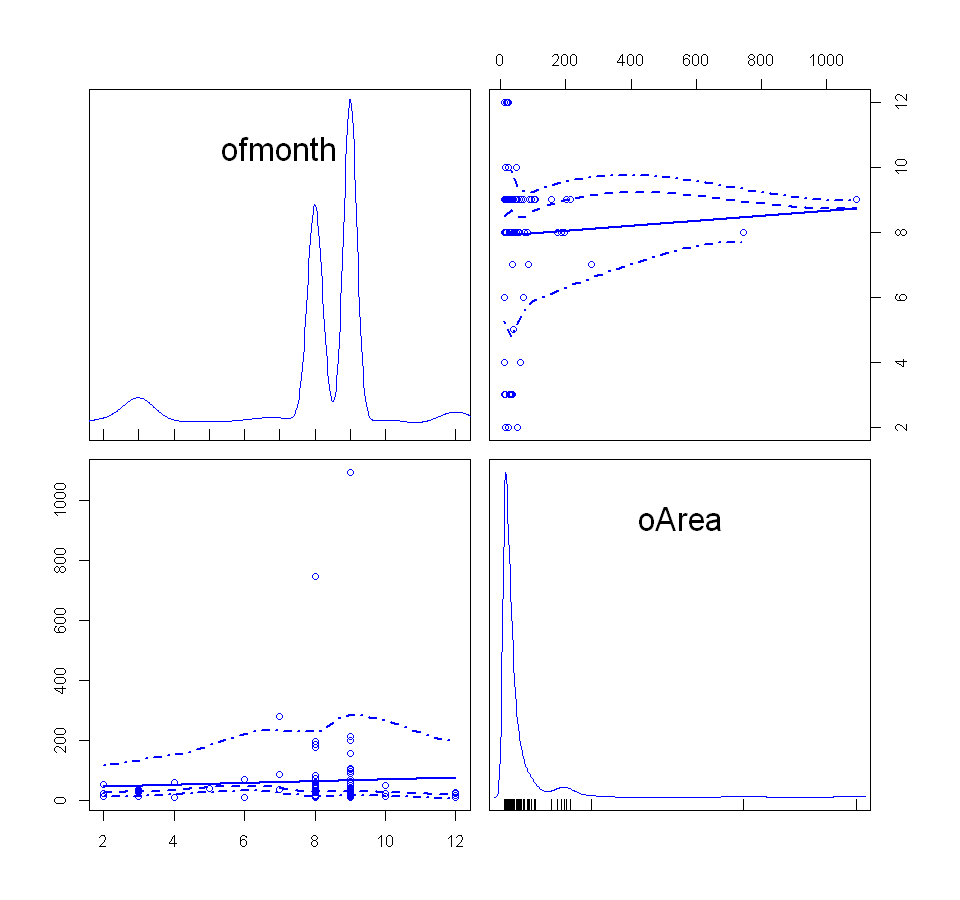

In [129]:
# 1. Bivariate relationship: month vs Area
scatterplotMatrix(~ofmonth + oArea, data=frame_data2)

### Temperature

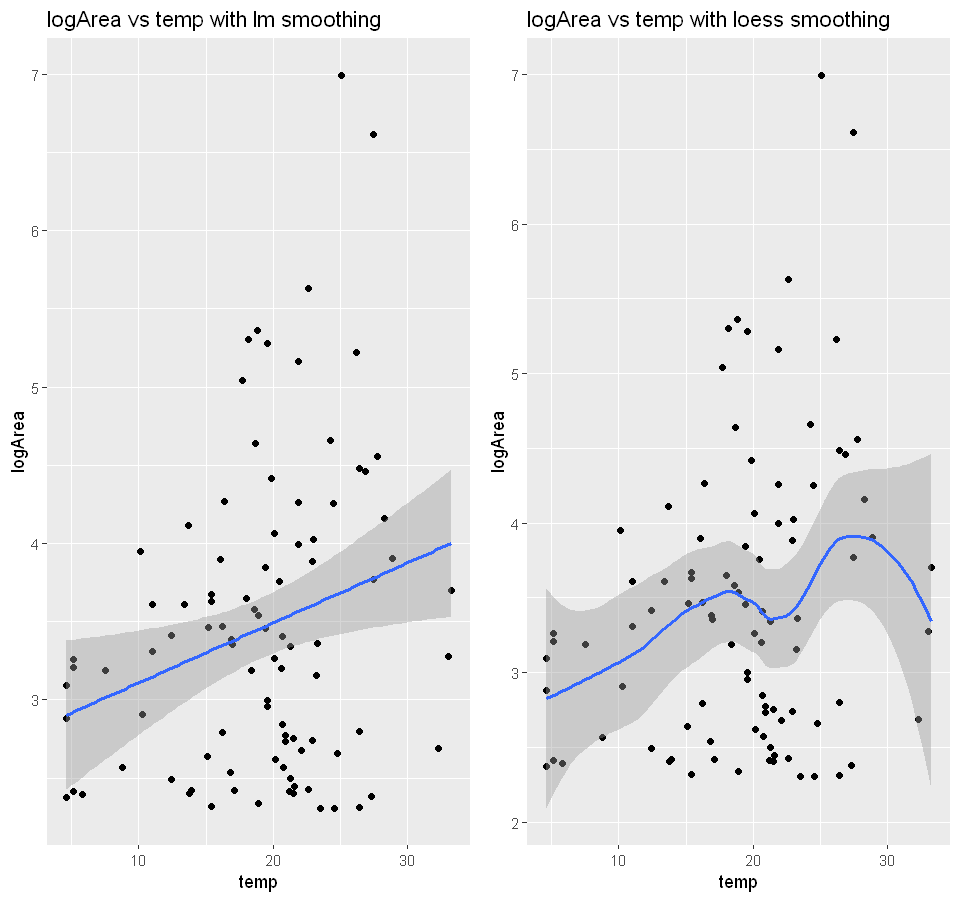

In [130]:
BivariatePlots(bff, 'logArea', 'temp')

# plot1 = ggplot(data=bff, aes(temp,logArea))  +geom_point() + geom_smooth(method = "lm") +
#             ggtitle(paste("LogArea vs", "temp", "with lm smoothing"))
# plot2 = ggplot(data=bff, aes(temp,logArea))  +geom_point() + geom_smooth(method = "loess") +
#             ggtitle(paste("LogArea vs", "temp", "with loess smoothing"))
# grid.arrange(plot1, plot2, nrow=1)

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 5 rows containing missing values (geom_point)."

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 5 rows containing missing values (geom_point)."

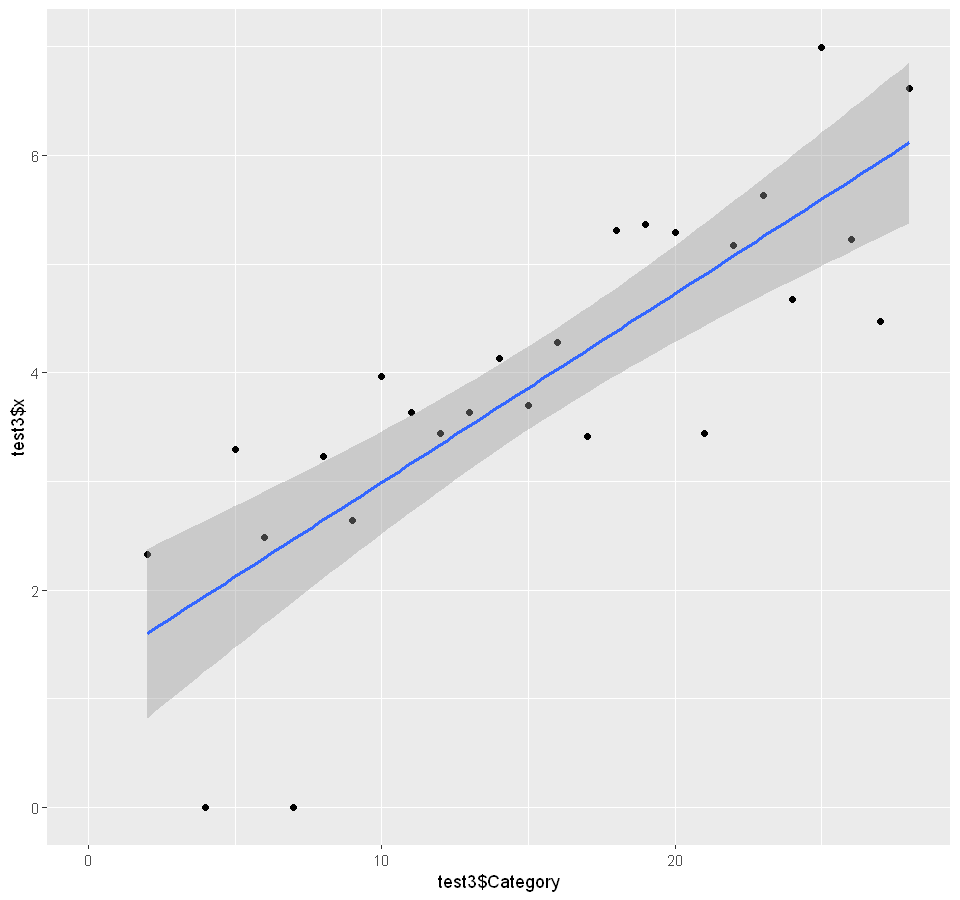

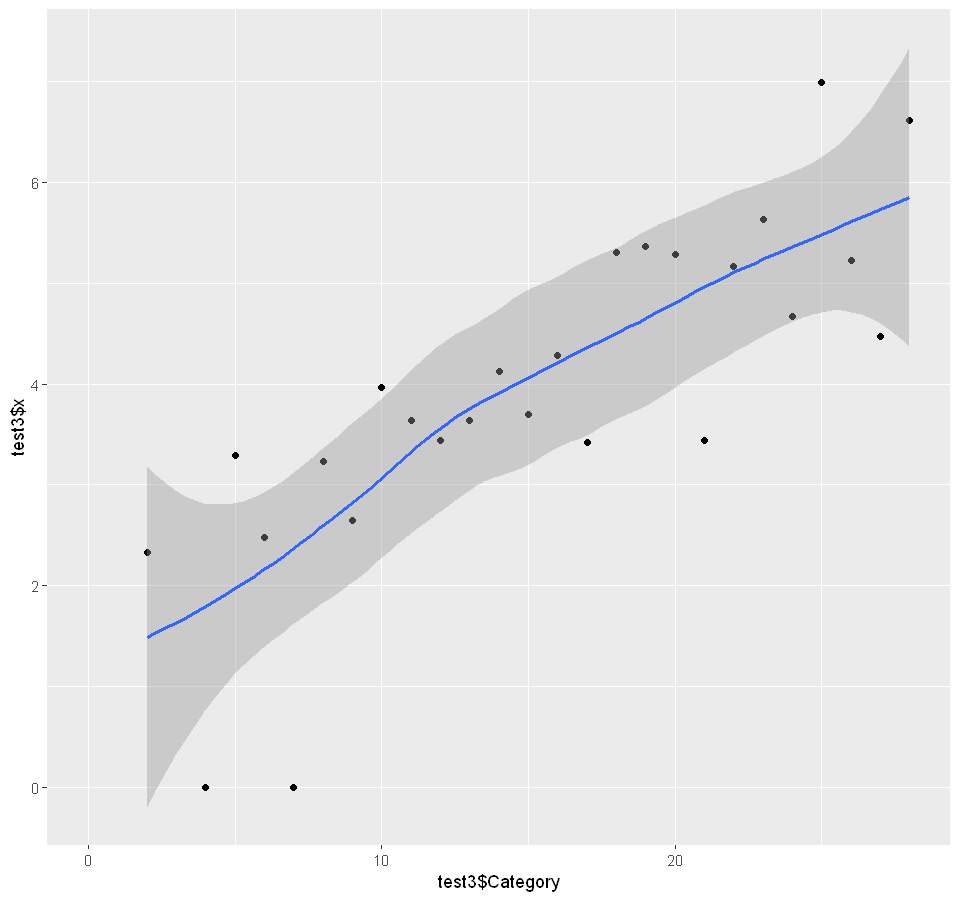

In [131]:
# grouping and choose only max value

test=data.frame(oTemp2=round(oTemp), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oTemp2), max)
# plot(test3$Category, test3$x)
# m1<-lm(test3$x ~ test3$Category, data=test3)
# abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="glm")+ xlim(0,28)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") + xlim(0,28)

Could visualize temperatures effect by making a stacked histogram of area, colorized by average temperature?

#### FFMC (Fine Fuel Moisture Code)

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 7 rows containing missing values (geom_point)."Warning message:
"Removed 7 rows containing missing values (geom_point)."

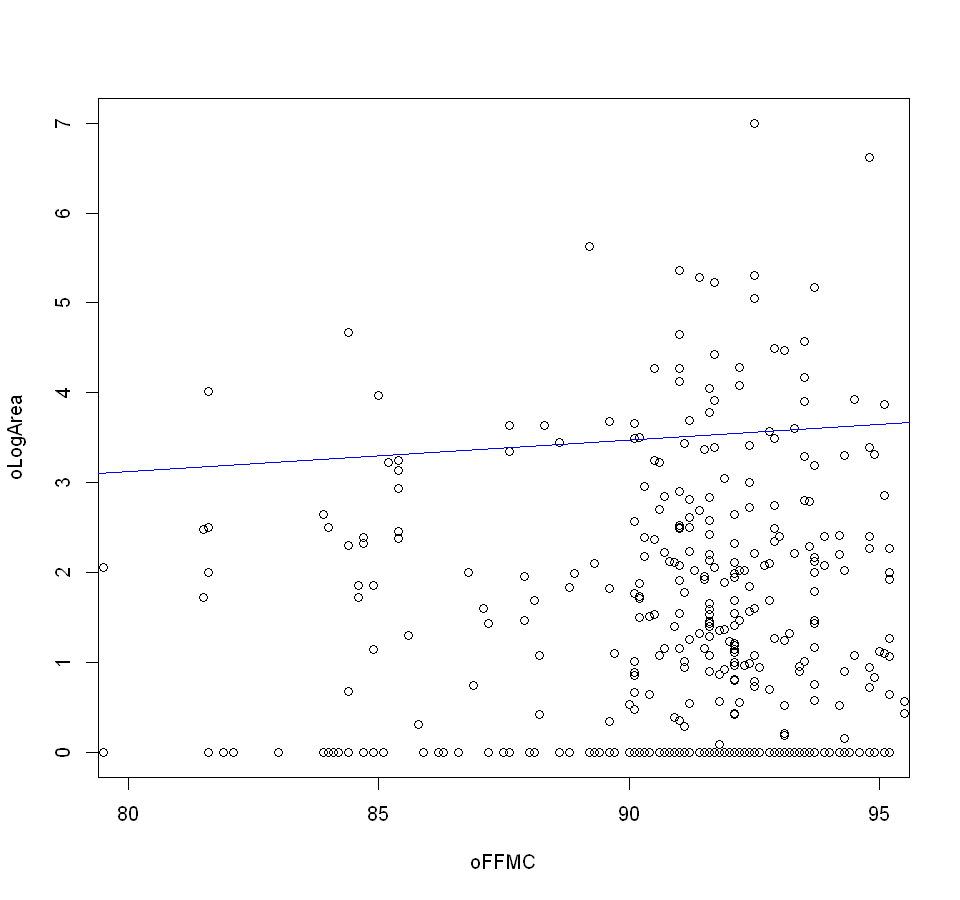

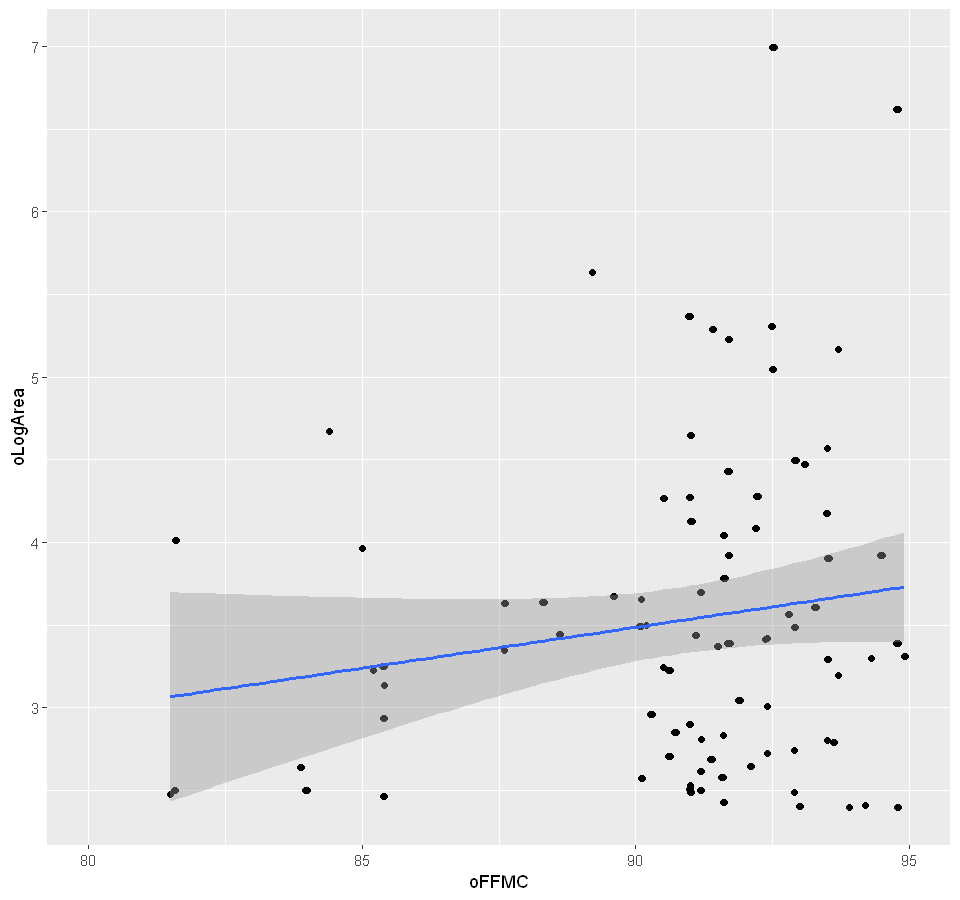

In [132]:
# 5. Bivariate relationship: FFMC vs Area
# no processing 
plot(oFFMC, oLogArea, xlim=c(80,95))
m1<-lm(oLogArea ~ oFFMC, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oFFMC,oLogArea)) +  geom_jitter() + geom_point() + geom_smooth(method = "gam") + xlim(80,95)

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

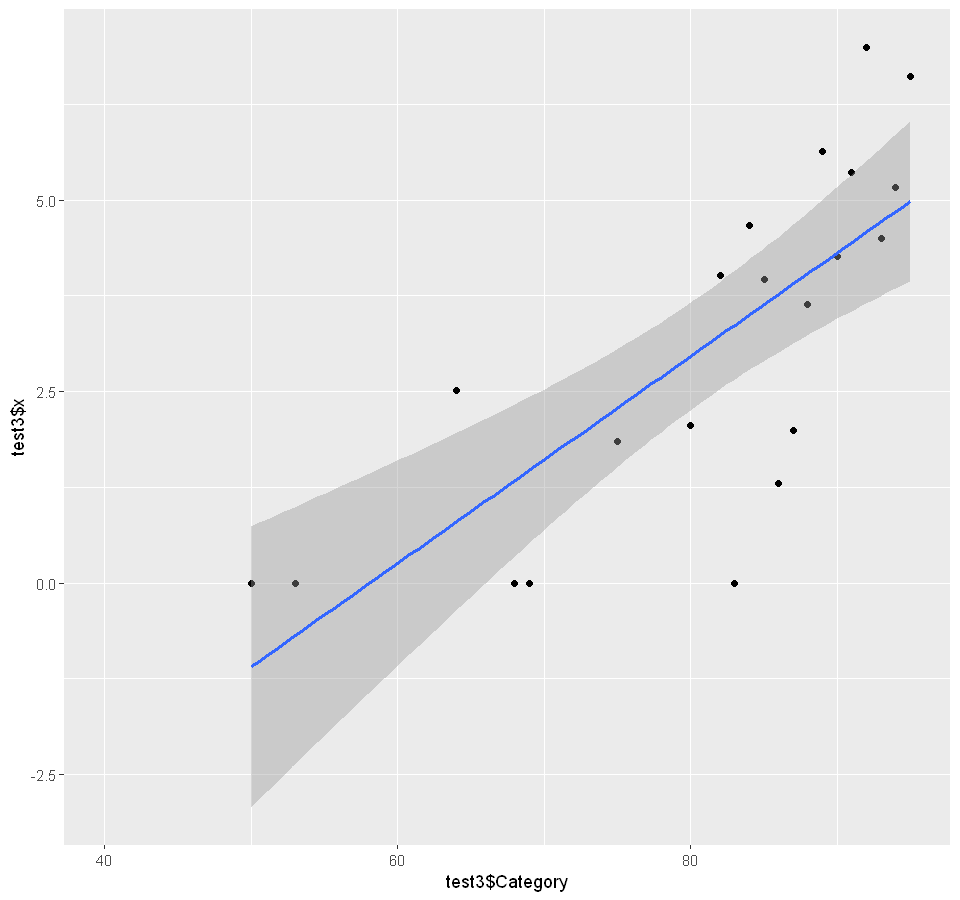

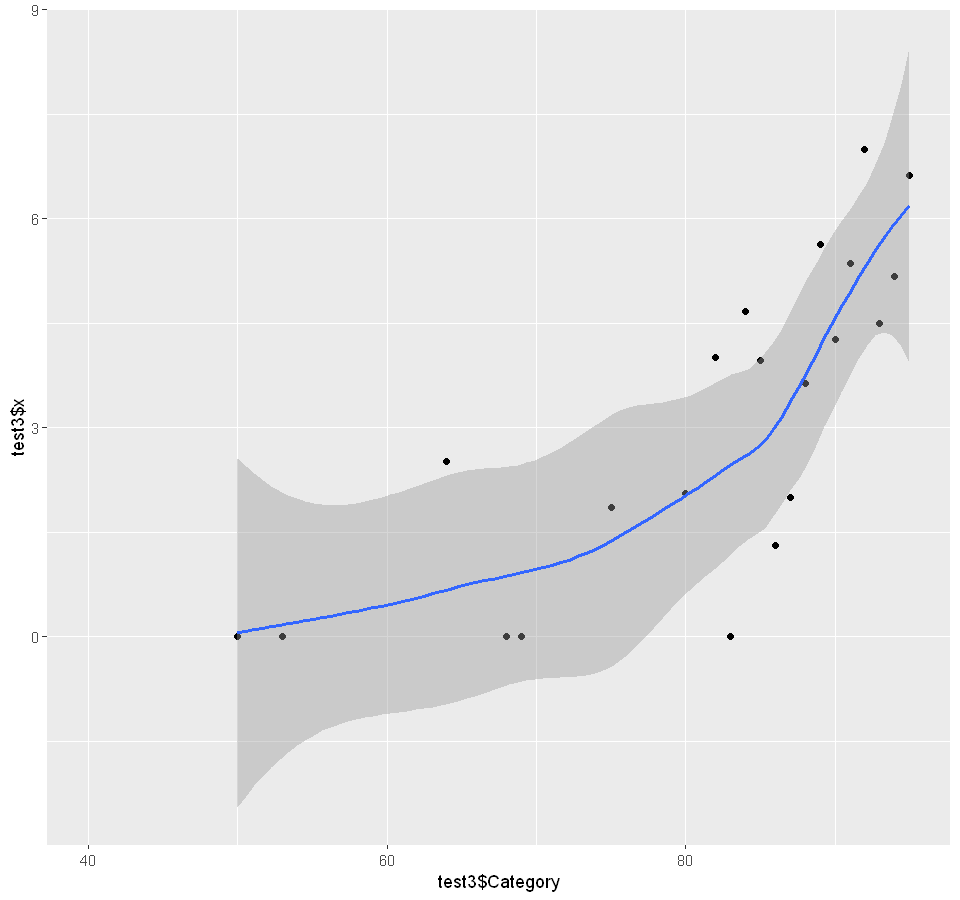

In [133]:
# grouping and choose only max value

test=data.frame(oFFMC2=round(oFFMC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oFFMC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") +xlim(40,95)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") +xlim(40,95)

#### Relative Humidity

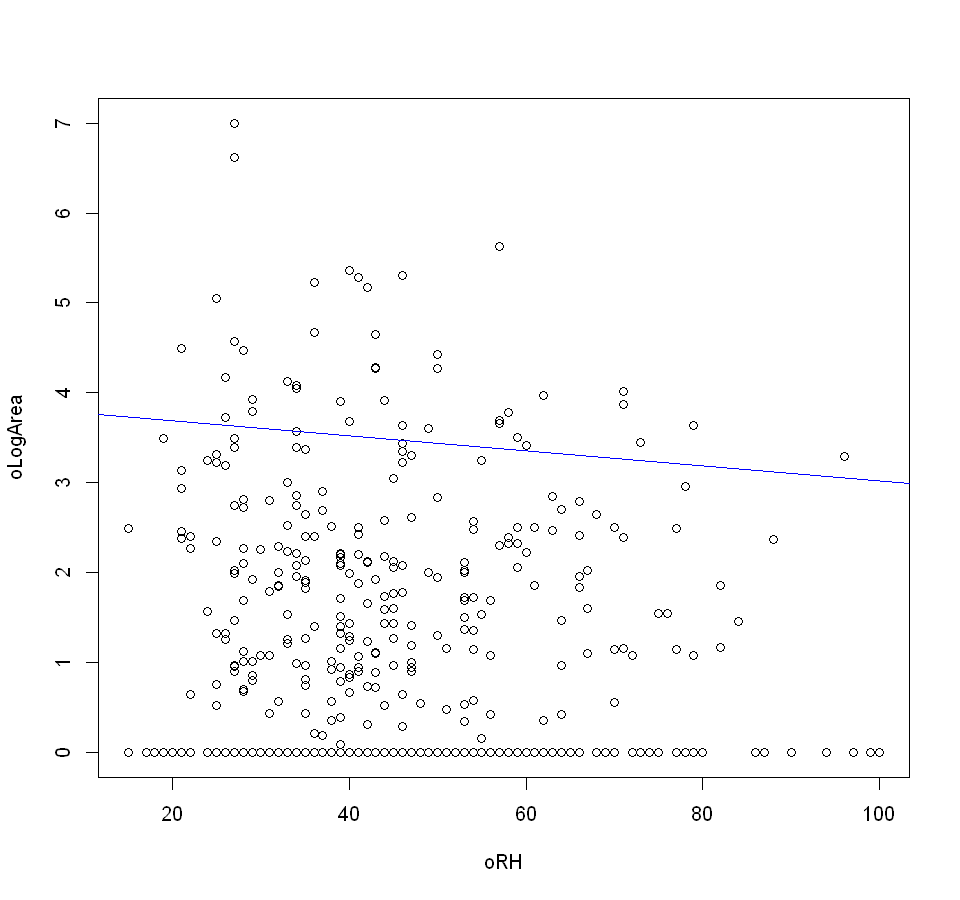

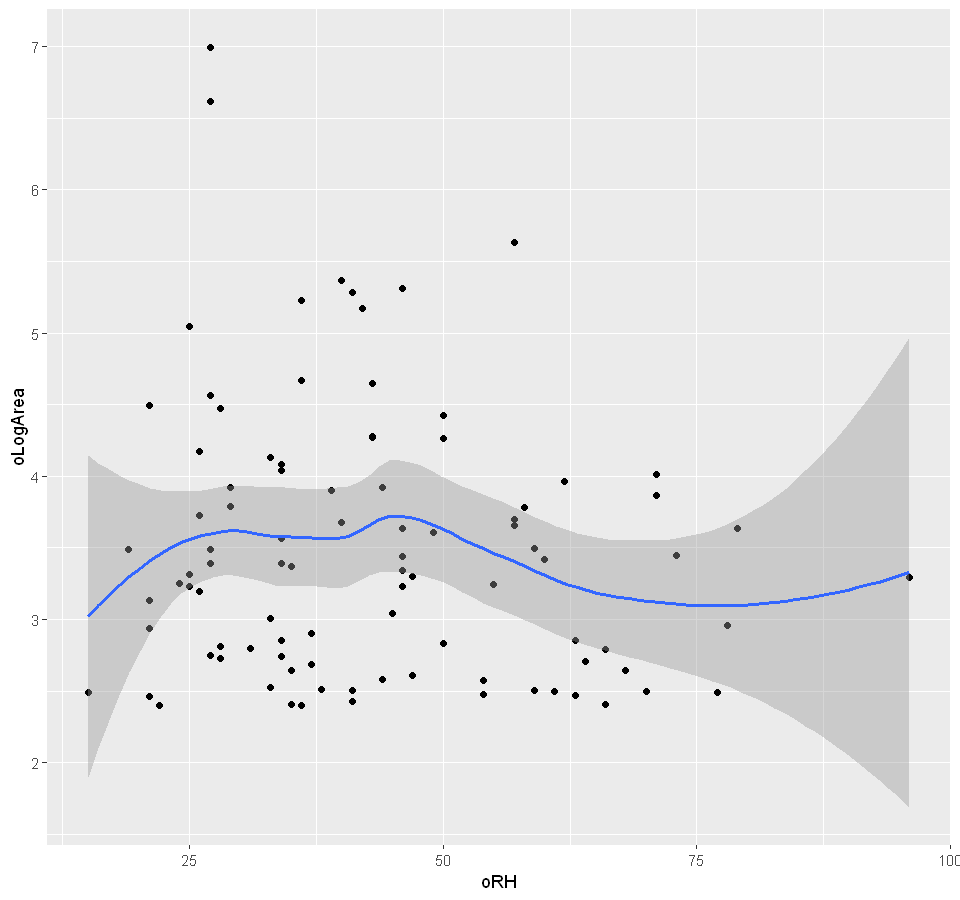

In [134]:
# 4. Bivariate relationship: RH vs Area  
# no processing

plot(oRH, oLogArea)
m1<-lm(oLogArea ~ oRH, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oRH,oLogArea)) + geom_point() + geom_smooth(method = "loess")

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 8 rows containing missing values (geom_point)."

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 8 rows containing missing values (geom_point)."

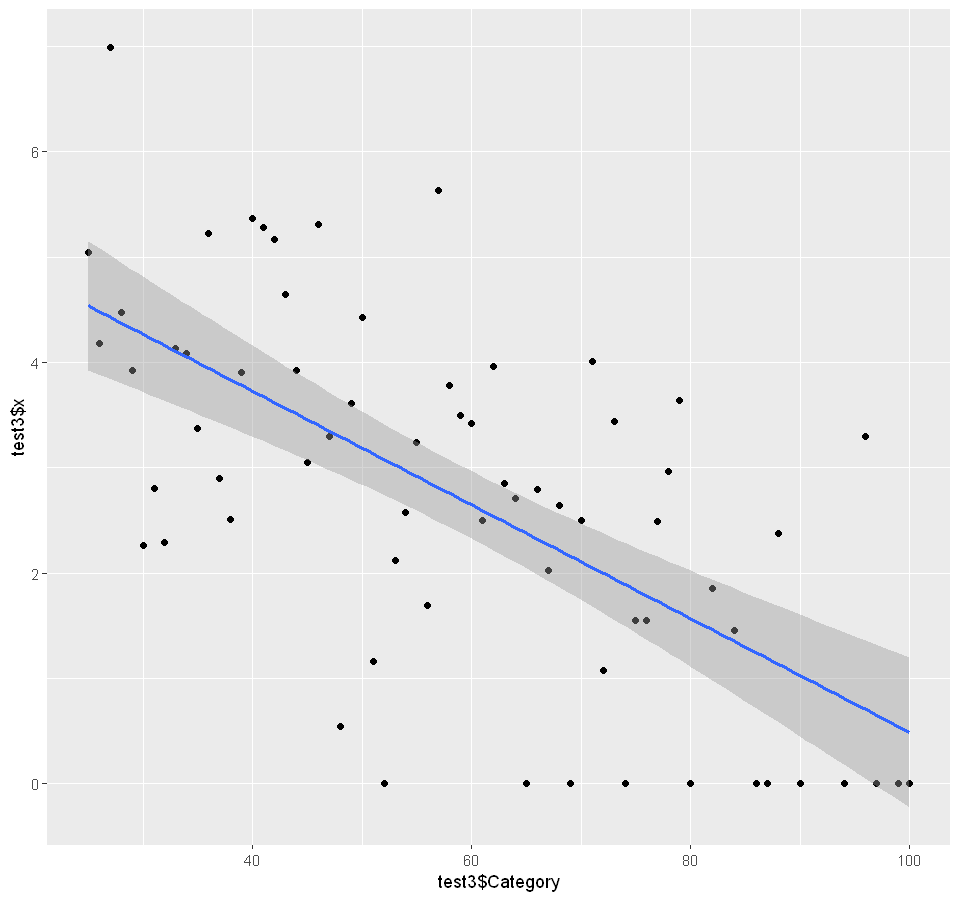

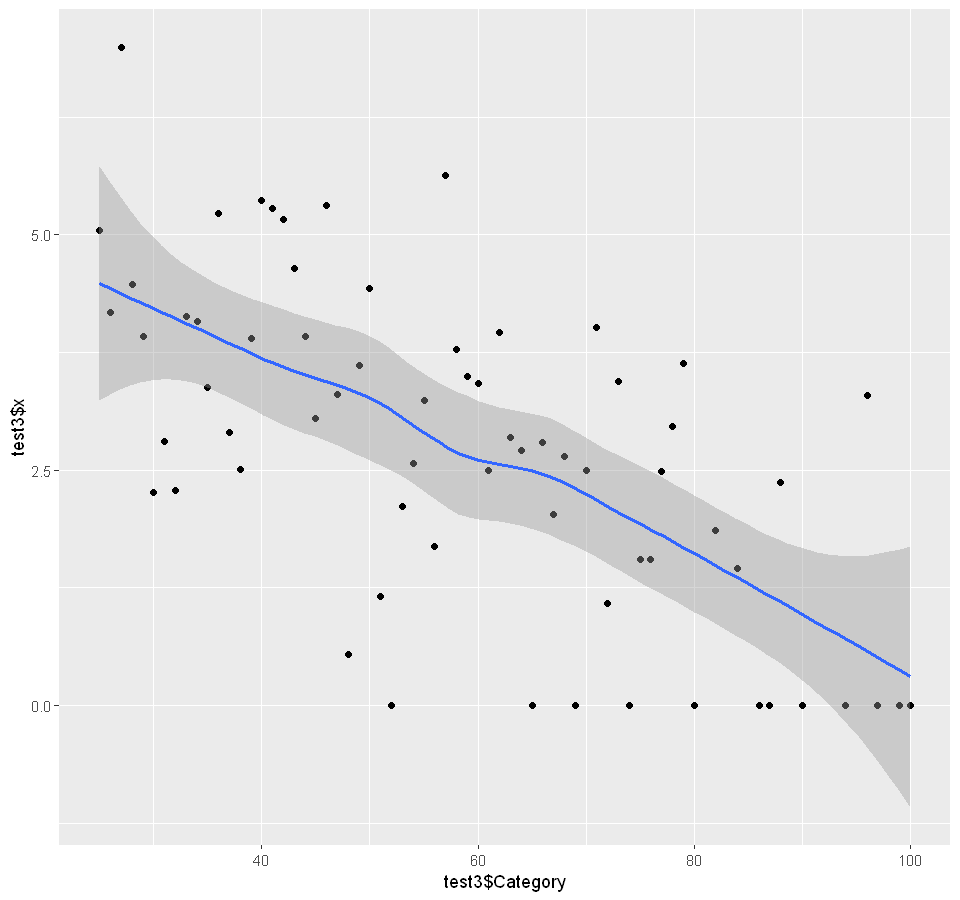

In [135]:
# grouping and choose only max value

test=data.frame(oRH2=round(oRH), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oRH2), max)

# plot(test3$Category, test3$x)
# m1<-lm(test3$x ~ test3$Category, data=test3)
# abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="glm")+xlim(25,100)
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess") +xlim(25,100)

### Secondary Area Relationships

#### Day

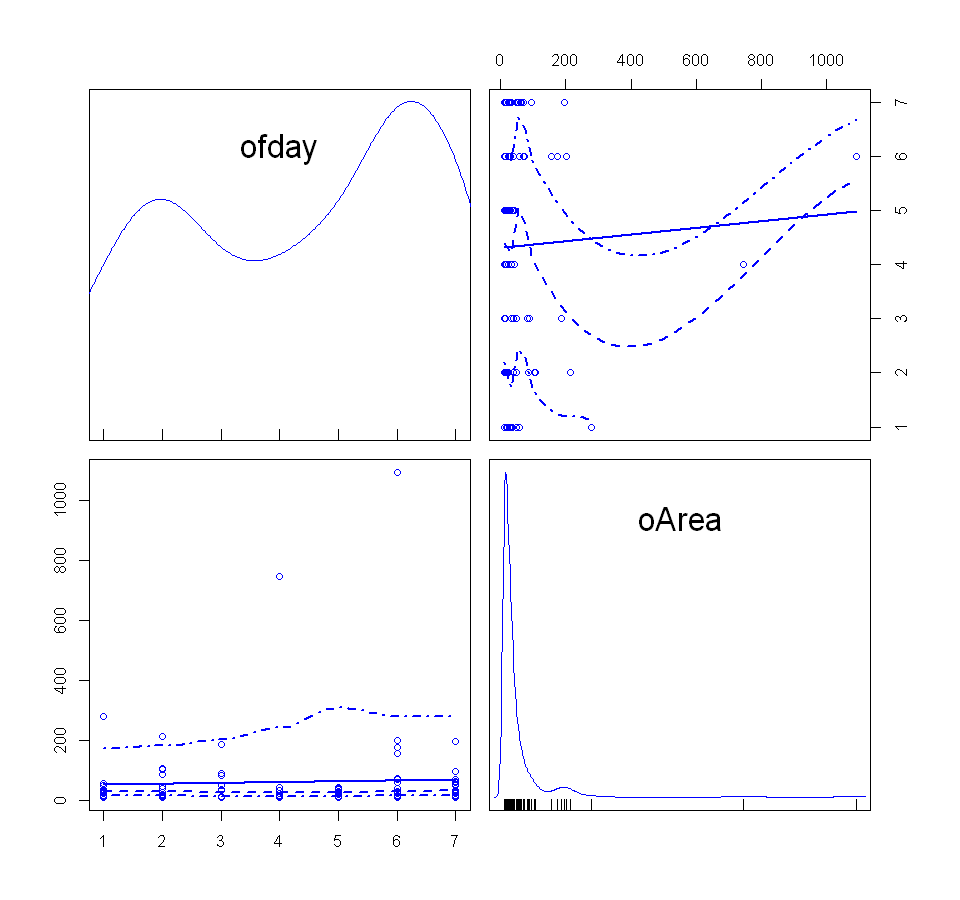

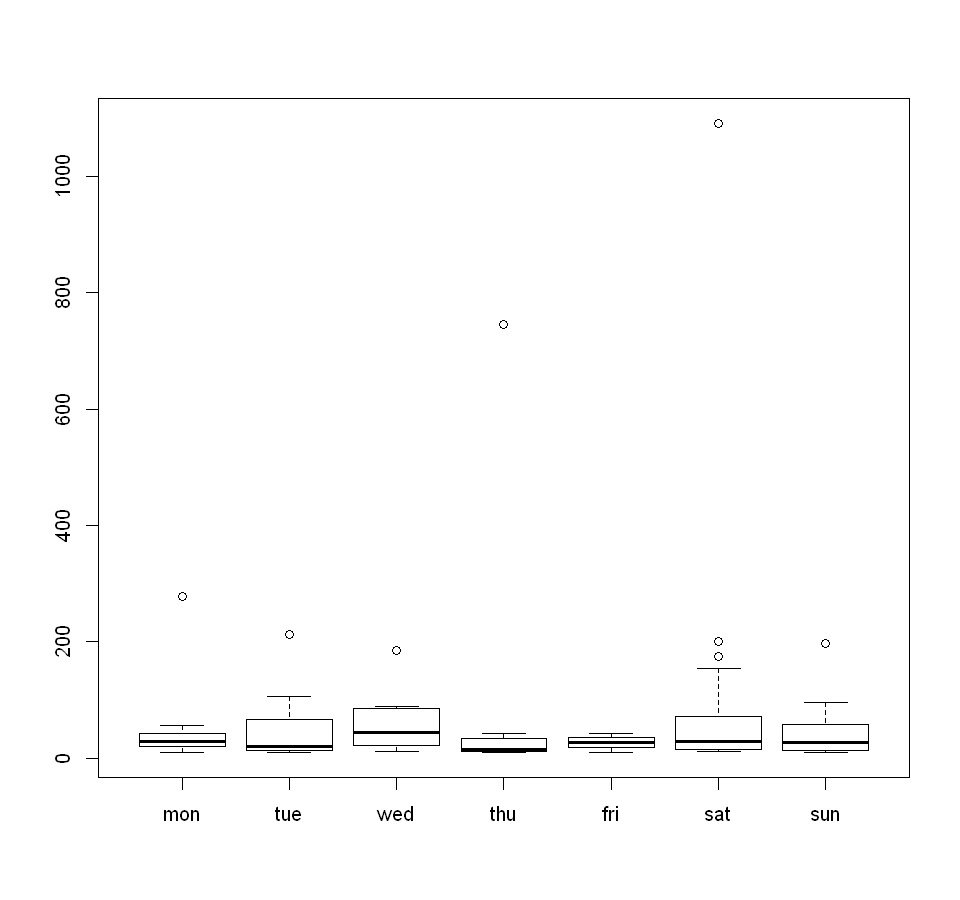

In [136]:
# 2. Bivariate relationship: day vs Area
scatterplotMatrix(~ofday + oArea, data=frame_data2)
boxplot(oArea~ofday,data=frame_data2)

#### DC (Drought Code)

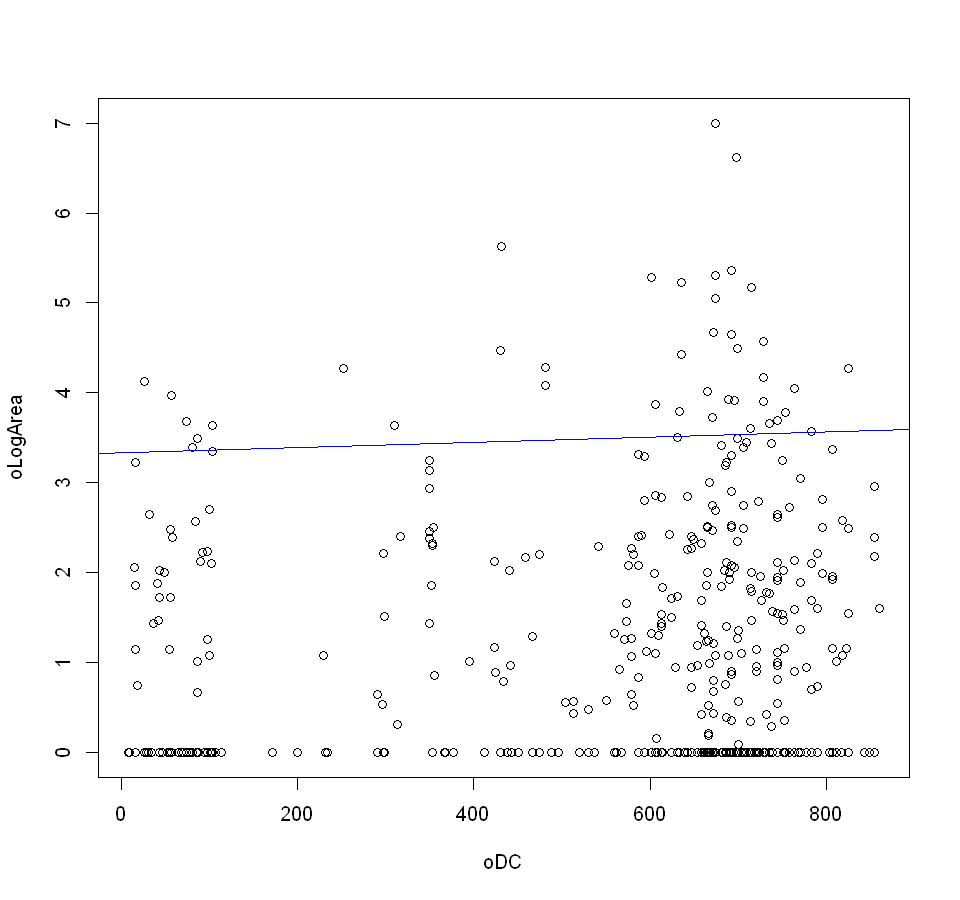

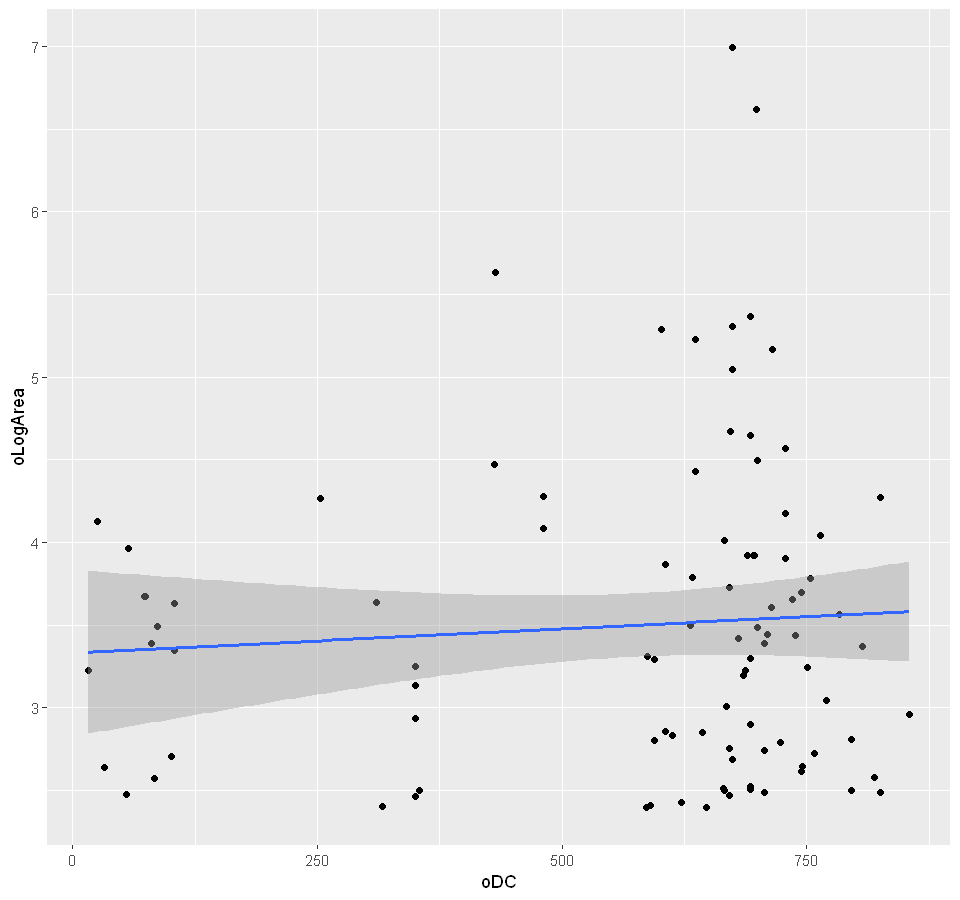

In [137]:
# 7. Bivariate relationship: DC vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
plot(oDC, oLogArea)
m1<-lm(oLogArea ~ oDC, data=frame_data2)
abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oDC,oLogArea)) + geom_jitter()+geom_point() + geom_smooth(method = "glm") 

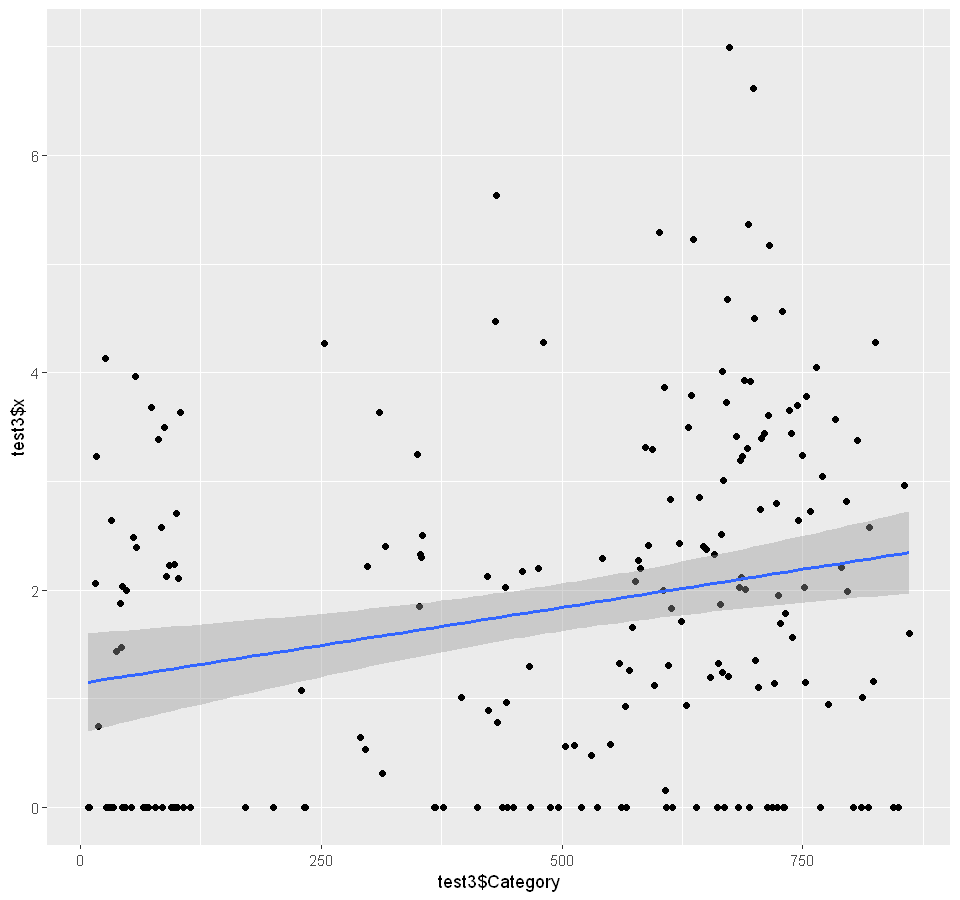

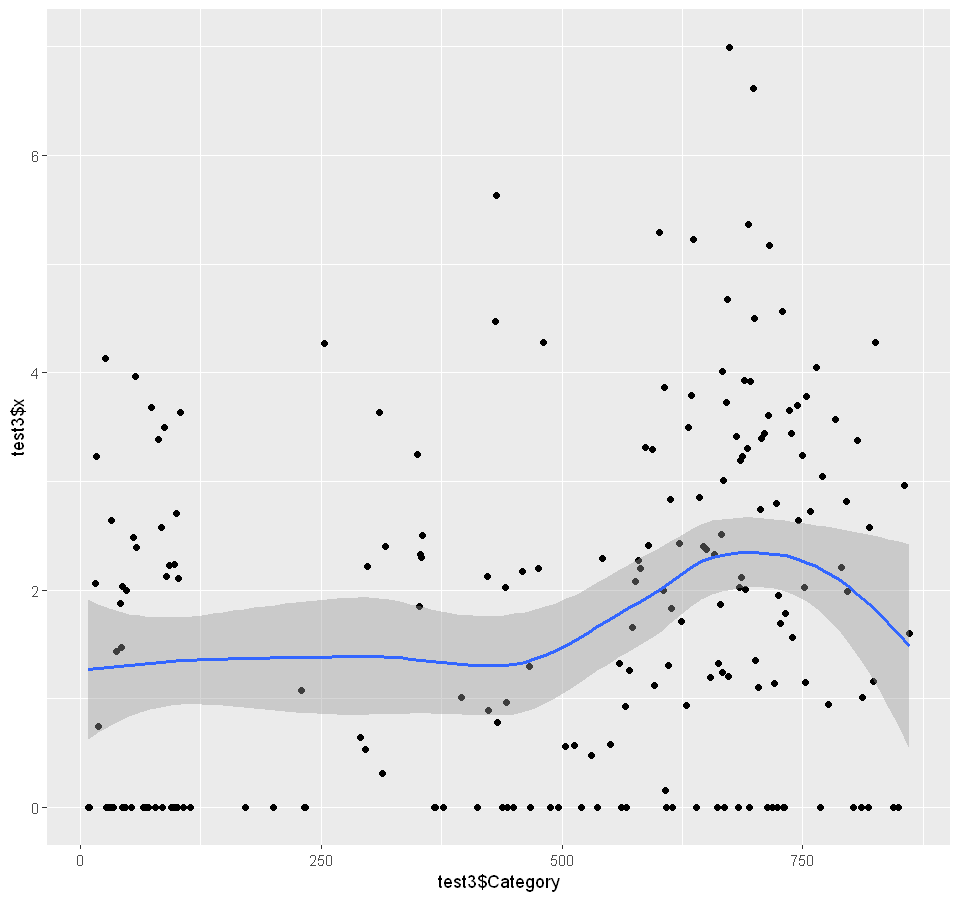

In [138]:
# grouping and choose only max value

test=data.frame(oDC2=round(oDC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oDC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

#### DMC (Duff Moisture Code)

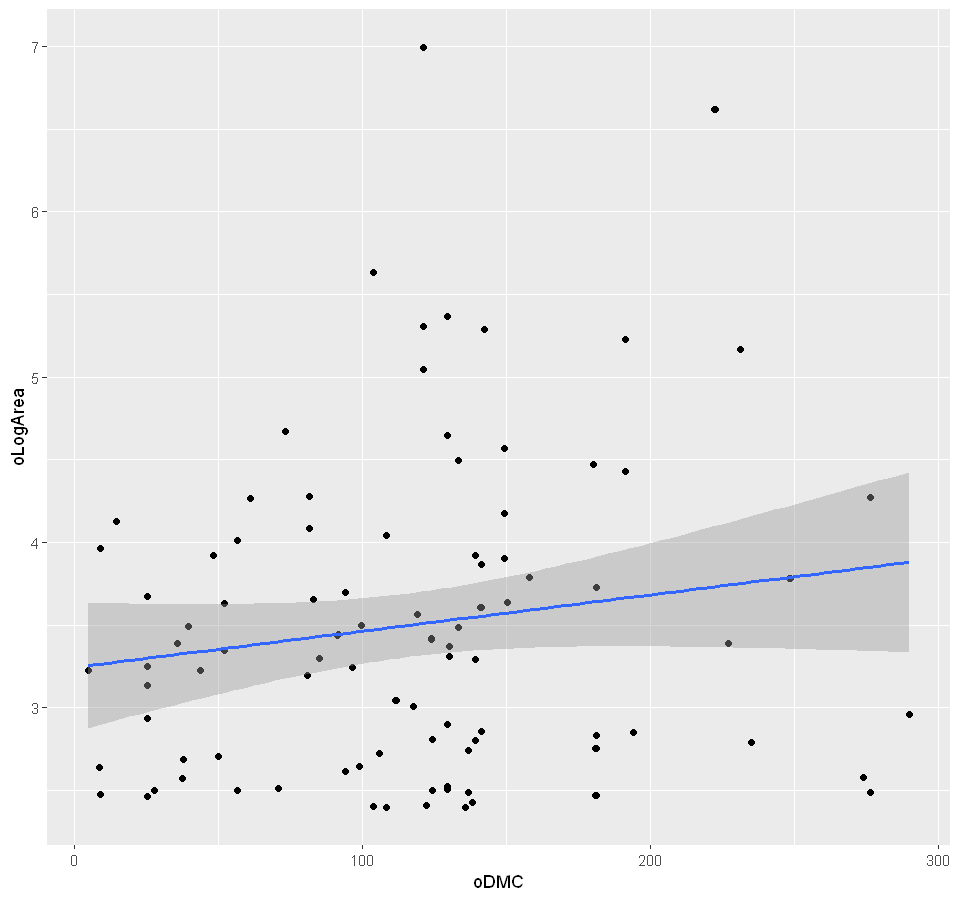

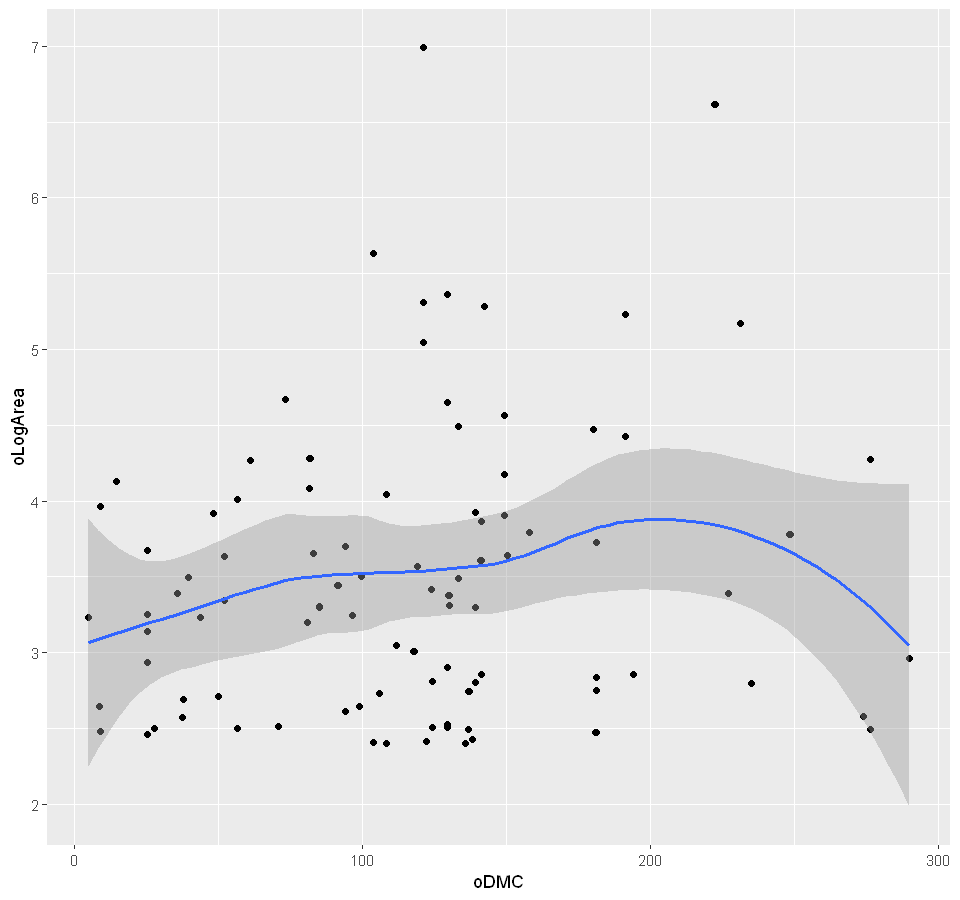

In [139]:
# 6. Bivariate relationship: DMC vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
# plot(oDMC, oLogArea)
# m1<-lm(oLogArea ~ oDMC, data=frame_data2)
# abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oDMC,oLogArea)) + geom_jitter() + geom_point() + geom_smooth(method = "lm") 
ggplot(data=frame_data2, aes(oDMC,oLogArea)) + geom_jitter() + geom_point() + geom_smooth(method = "loess") 

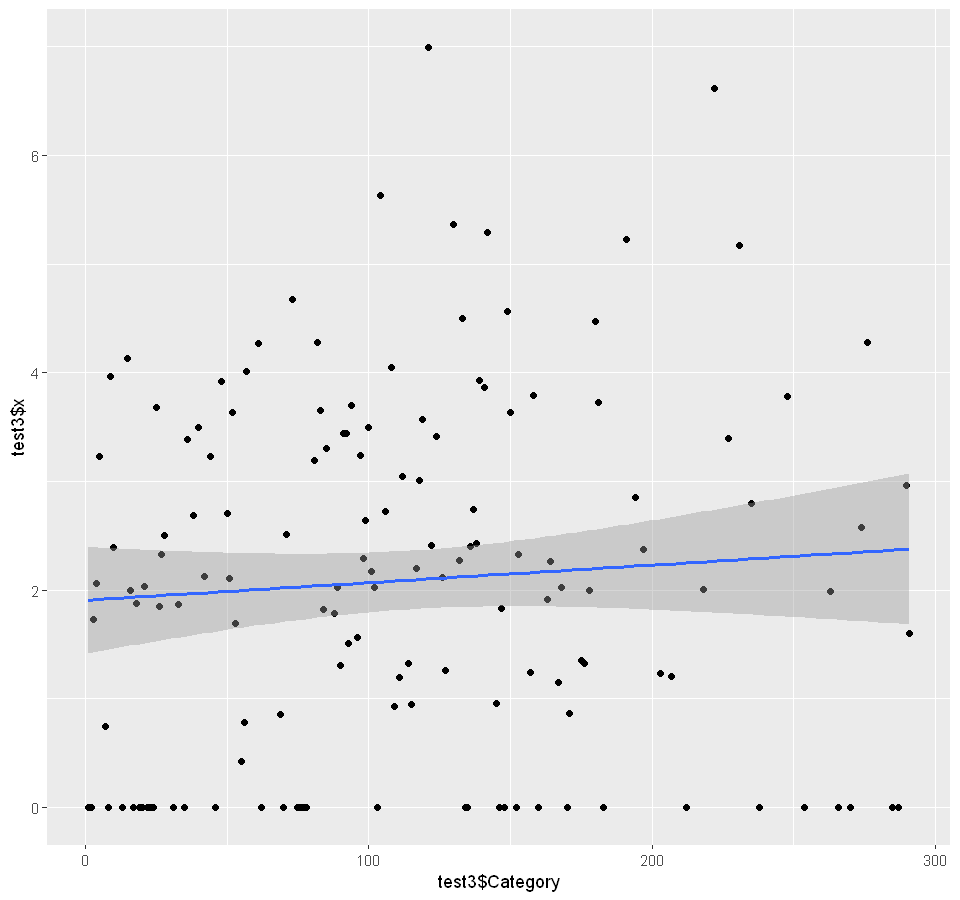

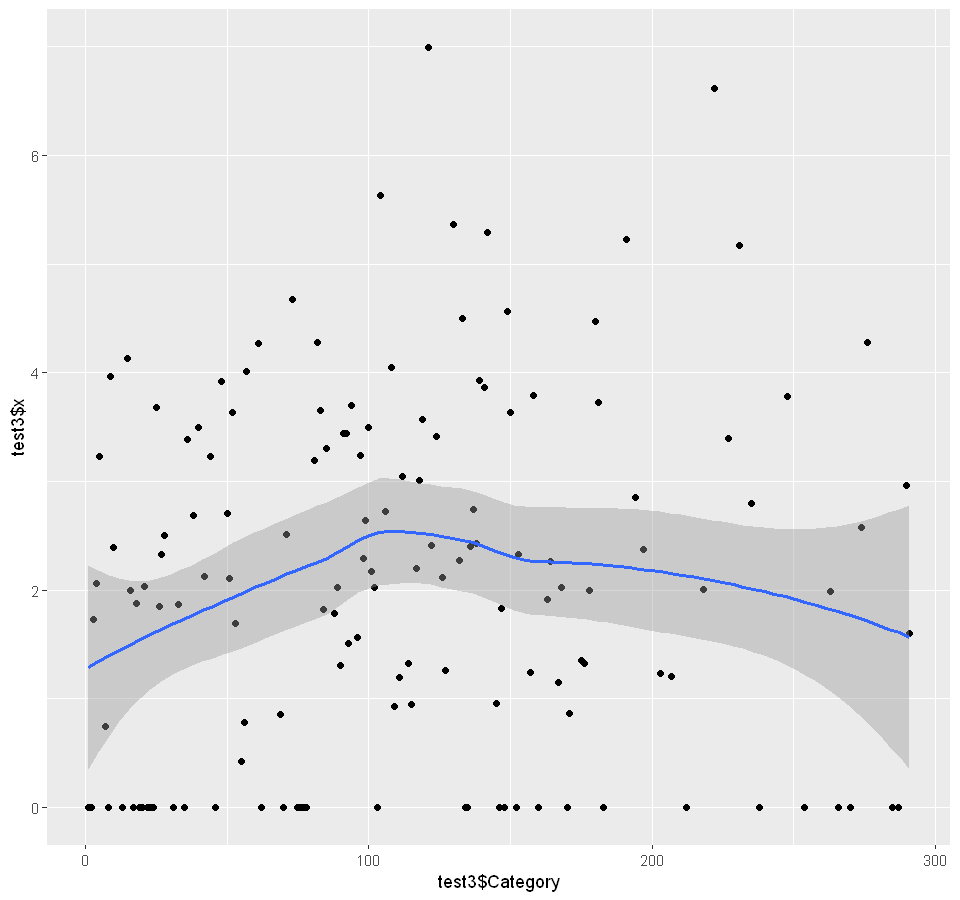

In [140]:
# grouping and choose only max value

test=data.frame(oDMC2=round(oDMC), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oDMC2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

### No Area Relationships

#### ISI (Initial Spread Index)

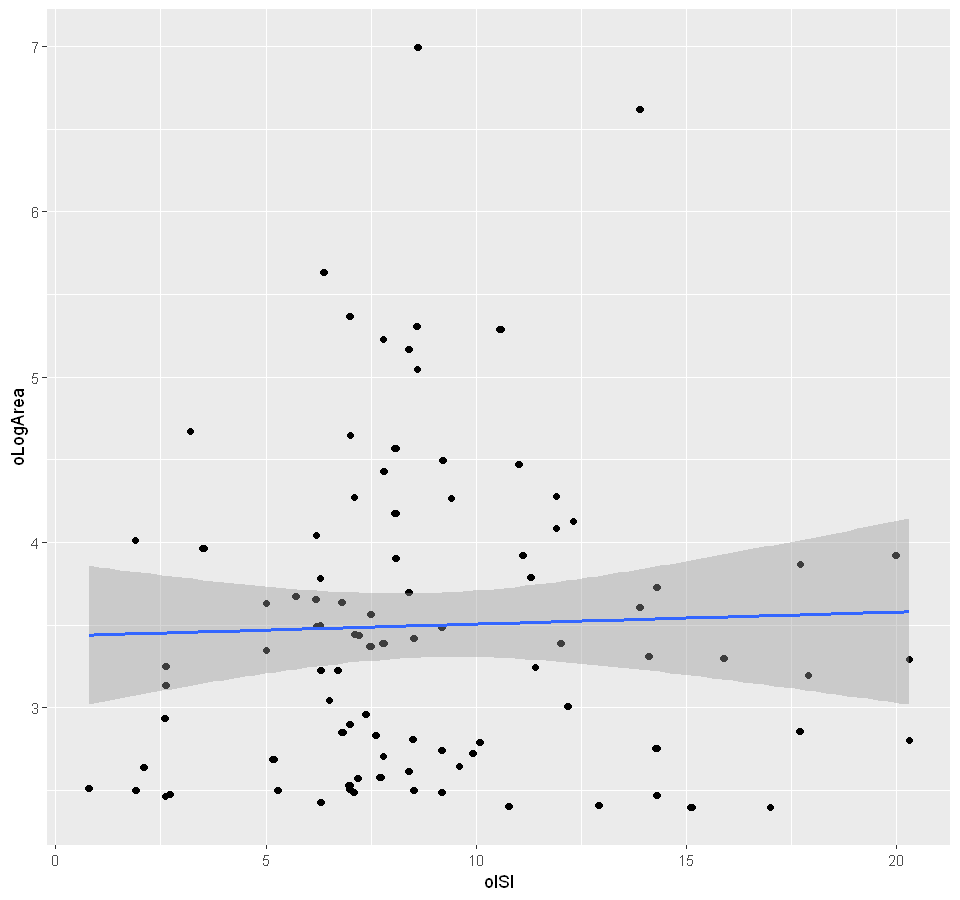

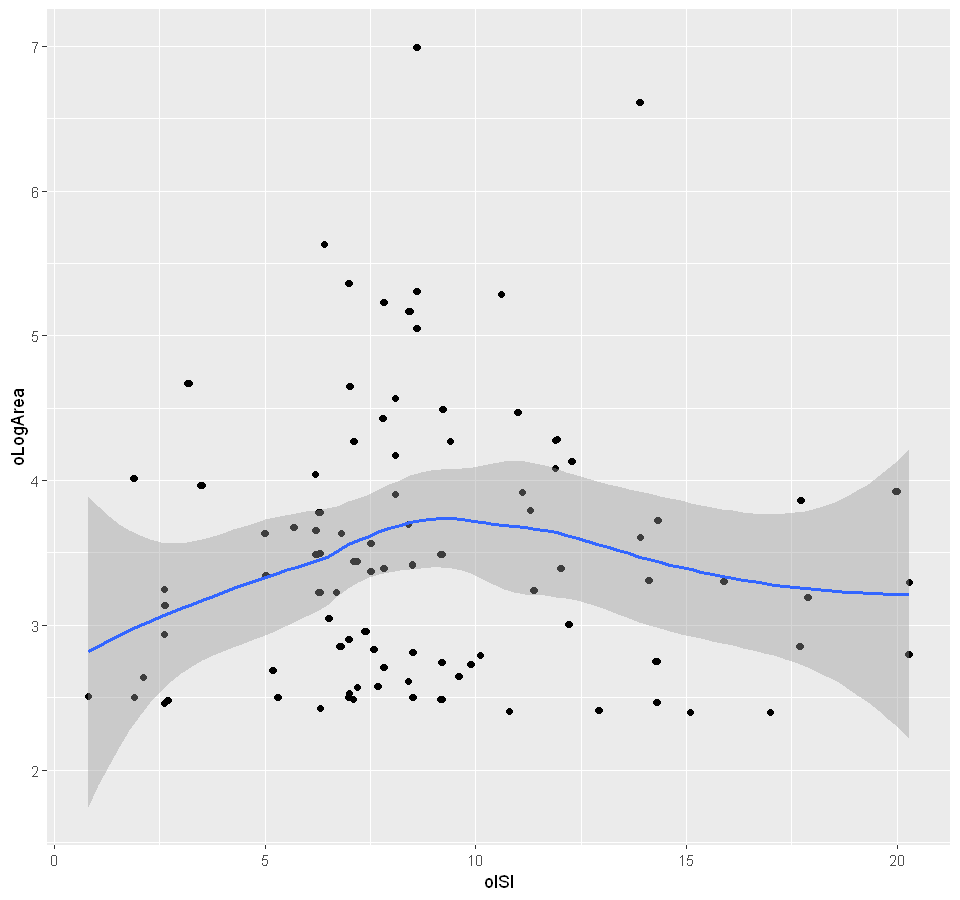

In [141]:
# 8. Bivariate relationship: ISI vs Area
#frame_data = data.frame(ofmonth,ofday, oArea, oLogArea, oRH, oTemp, oFFMC, oDMC, oDC, oISI)
# plot(oISI, oLogArea)
# m1<-lm(oLogArea ~ oISI, data=frame_data2)
# abline(coef(m1), col = "blue")
ggplot(data=frame_data2, aes(oISI,oLogArea)) + geom_jitter() +geom_point() + geom_smooth(method = "lm") 
ggplot(data=frame_data2, aes(oISI,oLogArea)) + geom_jitter() +geom_point() + geom_smooth(method = "loess") 

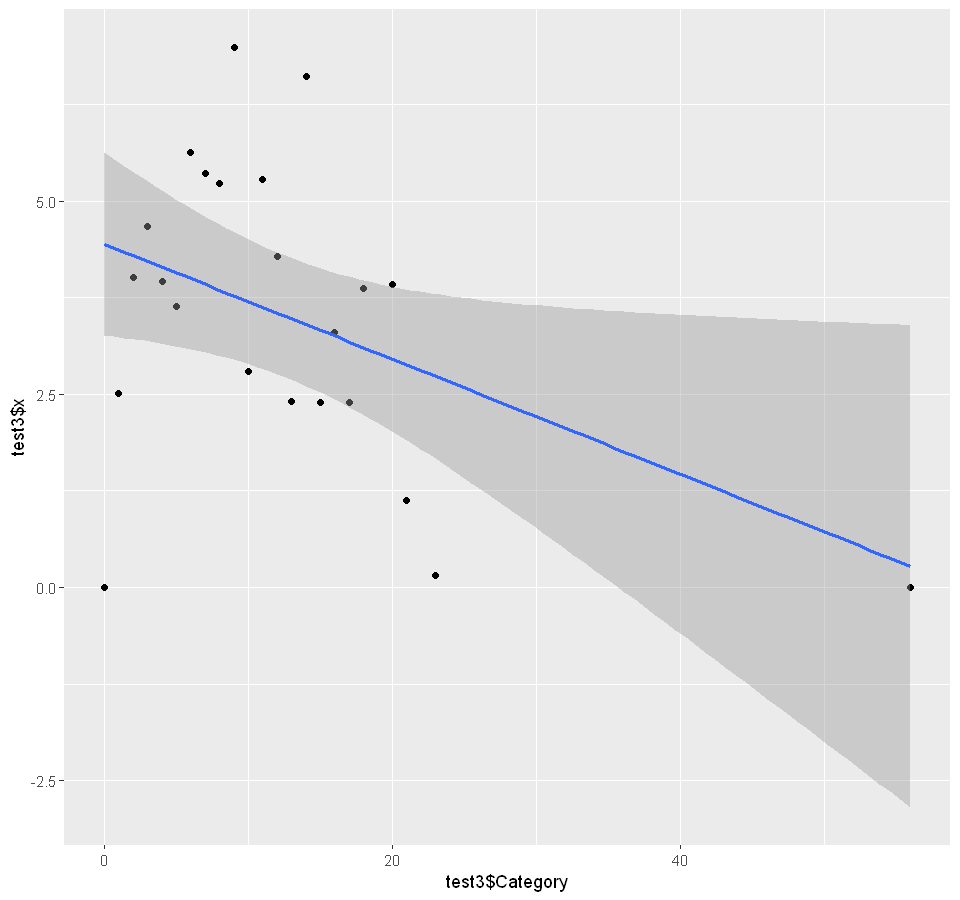

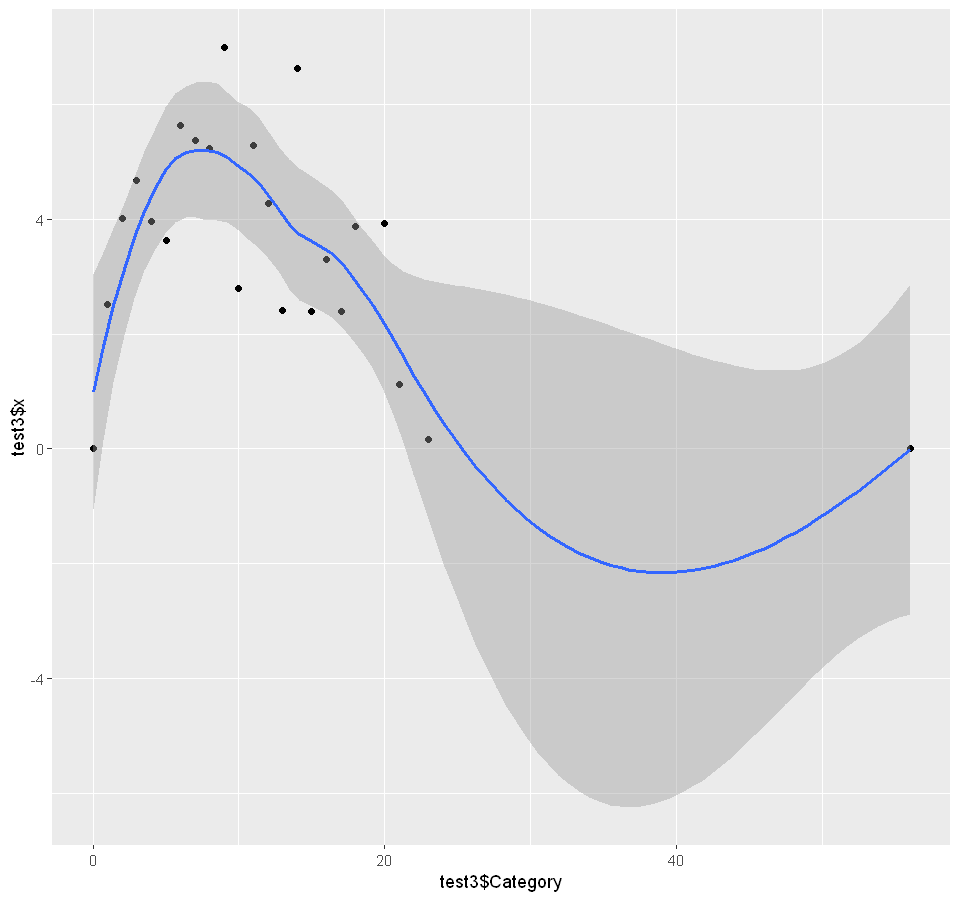

In [142]:
# grouping and choose only max value

test=data.frame(oISI2=round(oISI), oLogArea)
test3=aggregate(test$oLogArea, by = list(Category=test$oISI2), max)

#plot(test3$Category, test3$x)
#m1<-lm(test3$x ~ test3$Category, data=test3)
#abline(coef(m1), col = "blue")
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="lm") 
ggplot(data=test3, aes(test3$Category,test3$x)) + geom_point() + geom_smooth(method="loess")

#### Wind

#### Rain

## Secondary Effects

- Interactions between temperature and Month
- FFMC / DMC
- 

## Conclusion

## Helper Functions

In [143]:
FancyHist <- function(df, var, bins=100, width = 7, whRatio = 1/2){
    w_h_ratio = whRatio
    width = width
    options(repr.plot.width=width, repr.plot.height=width*w_h_ratio)
    #Takes a data frame and a string variable name in that data frame and produces a histogram of it
    varMean = mean(df[,var])
    varSD = sd(df[,var])
    
    return(
        ggplot(df, aes_string(var)) +
          geom_histogram(bins=bins, fill="red", color="black") + 
          geom_vline(aes(xintercept = varMean), colour="black", size = 1) + 
          geom_vline(aes(xintercept = varMean-varSD), colour="black", size = 0.5, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean+varSD), colour="black", size = 0.5, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean-2*varSD), colour="gray", size = 0.75, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean+2*varSD), colour="darkgray", size = 0.75, linetype="dashed") +
          ggtitle(paste("Histogram of ", var))
    )
}

BivariatePlots <- function(df, varY, varX){
    plot1 = ggplot(data=bff, aes_string(varX, varY))  +geom_point() + geom_smooth(method = "lm") +
            ggtitle(paste(varY, "vs", varX, "with lm smoothing"))
    plot2 = ggplot(data=bff, aes_string(varX, varY))  +geom_point() + geom_smooth(method = "loess") +
                ggtitle(paste(varY, "vs", varX, "with loess smoothing"))
    return(grid.arrange(plot1, plot2, nrow=1))
}